## Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')

# Databases
For the assessment, six databases were used to extract the predictors. These databases belong to the anonymised microdata of general Colombia Living Standard Survey (CLSS) of 2023 from the Colombian statistics department (DANE). The databases are separated depending on the topic or the level of disaggregation (House, family or individuals).
The link to the survey https://microdatos.dane.gov.co/index.php/catalog/827

The survey has plenty of variables. According to the literature review on clean cooking, the following were selected.

| DANE Variable | Description | Values | Database | Rename |
|----------|-------------|--------| --------| --------|
| DIRECTORIO | The identification code of the house  | Number | All databases | house_code |
| SECUENCIA_P | The identification code of the family  | Number | All databases | family_code |
| P8536 | Main source of energy for cooking (target variable) | 1. Electricity, 2. Natural gas (public grid), 3.  Oil, kerosene, alcohol, 4. LPG, 5. Mineral coal, 6. Firewood, 7. Wood charcoal, 8. Waste material | services_data | energy_cook |
| P5666 | Connection to natural gas | 1: Yes, 2: No | services_data | gas |
| P764 | Place where cooking occurs | 1: Kitchen, 2: Bedroom, 3: Dining room without dishwasher, 4: Dining room with dishwasher, 5: Outside, 6: Don't cook | services_data | place_cook |
| PERCAPITA | Family income divided by number of people | Number |  services_data | PERCAPITA |
| CANT_PERSONAS_HOGAR | Number of people in the family | Number |  services_data | people_count |
| CLASE | Urban/rural classification | 1: Urban, 2: Rural  | house_data | urban |
| P2102 | Type of road access to the house | 1: Path or river, 2: Walking pavement way, 3: Vehicle non-paved road, 4: Vehicle paved road | house_data | road_access |
| P1070 | Type of house | 1: House, 2: Apartment, 3: Room, 4: Indigenous or traditional, 5: Other | house_data | house_type |
| P8520S1 | If the house has access to energy (public grid) | 1: Yes, 2: No | house_data | energy |
| P8520S5 | If the house has access to water (public grid) | 1: Yes, 2: No | house_data | water |
| P8520S5 | If the house has access to water (public grid) | 1: Yes, 2: No | house_data | garbage |
| P8520S3 | If the house has access to sewage (public service) | 1: Yes, 2: No | house_data | sewage |
| P8587 | Maximum education level of a family member | 1: Illiterate, 2: kinder, 3: primary, 4: secondary, 5: high school, 6: unfinished technical course, 7: technical course, 8: unfinished technological school, 9: technological school, 10: unfinished undergraduate, 11: Undergraduate, 12: unfinished postgraduate, 13: postgraduate | educ_data | max_edu |
| P6040 | Age of each member of the family | Number  | age_data | min_age, max_age |
| P1077S2 | Access to fridge | 1: Yes, 2: No | possesions_data | fridge |
| P1077S3 | Access to stove | 1: Yes, 2: No | possesions_data | stove |
| P1913S7 | Walking minutes to park or green zone | Number of minutes | possesions_data | green_access |
| P5095 | Type of house tenancy | 1: Own, 2: Paying, 3: Rent, 4: Residence without payment, 5: Possession without title, 6: Collective property | rent_data | house_tenancy |


In [2]:
#the surveys related to services, possesions and rent were answered by families.
#services_data contains the data of the dependent variable, the main energy source for cooking, as well as other variables related to other services
services_data= pd.read_csv("Servicios del hogar.CSV",sep=";",usecols=["DIRECTORIO","SECUENCIA_P","P5666","P764","P8536",
                               "PERCAPITA","CANT_PERSONAS_HOGAR"])
#posessions_data contains the data about goods and life conditions of a family
possesions_data = pd.read_csv("Condiciones de vida del hogar y tenencia de bienes.CSV",sep=";",usecols=["DIRECTORIO","SECUENCIA_P","P1077S3",
                                                                                                  "P1077S2","P1913S7"])
#rent_data contains information about the type of property rights (Own house, paying, rent, possesion without entitlement)
rent_data= pd.read_csv("Tenencia y financiación de la vivienda que ocupa el hogar.CSV",sep=";",usecols=["DIRECTORIO","SECUENCIA_P","P5095"])

#the survey related to the house were answered by the owner of the house. In a house could live different families not related.
#The information of the house such as access to services and type of the house
house_data = pd.read_csv("Datos de la vivienda.CSV", sep=";",usecols=["DIRECTORIO","CLASE","P2102","P1070","P8520S1","P8520S5","P8520S3","P8520S4"])

#the survey related to education and age were answered by individuals. In the following steps, the information will be aggregated to household level
educ_data = pd.read_csv("Educación.CSV", sep=";",usecols=["DIRECTORIO","SECUENCIA_P","P8587"])
age_data= pd.read_csv("Características y composición del hogar.CSV",sep=";",usecols=["DIRECTORIO","SECUENCIA_P","P6040"])


The following lines will aggregate the data corresponding to individual level to household level and next, all the six databases will be merged into one. The main database for the merging will be the services_data which contains the dependent variable and also is at household level.

In [3]:
# Group by 'Directorio' (ID of the house) and 'Secuencia_P' (ID of the household) and aggregate to find the max of 'education' and min and max age
#The max_education is the maximum level of education that an individual has in a family. The variable contains information in numbers
# 1 from illiterate to 13 posgraduate finished. Therefore, there is no need to transform the variable to get the maximum
educ_data_agg = educ_data.groupby(["DIRECTORIO", "SECUENCIA_P"], as_index=False).agg(max_educ=('P8587', 'max'))
age_data_agg= age_data.groupby(["DIRECTORIO", "SECUENCIA_P"], as_index=False).agg(min_age=('P6040', 'min'),max_age=('P6040', 'max'))

In [4]:
#Merge of the databases based on the columns "Directorio" (ID of the house) and Secuencia_P (ID of the household)
datasets = [
    (house_data, ["DIRECTORIO"]), #house_data is house level therefore it will be merged solely on the ID of the house
    (educ_data_agg, ["DIRECTORIO", "SECUENCIA_P"]), #this is the new database that resulted from the aggregation and contains the maximum level of education
    (age_data_agg, ["DIRECTORIO", "SECUENCIA_P"]),
    (possesions_data, ["DIRECTORIO", "SECUENCIA_P"]),
    (rent_data, ["DIRECTORIO", "SECUENCIA_P"])]

# The merge will be iteratively starting from the services_data that is at household level and contains the dependent variable
db_main = services_data
for data, keys in datasets: #data will be the datasets and keys, the ID of each dataset depending if is house (Directorio) or family (Directorio & Secuencia_P)
    db_main = db_main.merge(data, how="left", on=keys)

db_main

,DIRECTORIO,SECUENCIA_P,P5666,P764,P8536,PERCAPITA,CANT_PERSONAS_HOGAR,CLASE,P2102,P1070,...,P8520S5,P8520S3,P8520S4,max_educ,min_age,max_age,P1077S2,P1077S3,P1913S7,P5095
0,7910114,1,1,1,2.0,3.875000e+05,2,1,3,1,...,1,1,1,5.0,16,43,1,1,10,3
1,7910115,1,2,1,1.0,4.400000e+05,5,2,1,1,...,1,2,1,5.0,1,54,1,1,20,6
2,7910119,1,2,1,4.0,2.050000e+05,2,2,1,1,...,1,2,2,4.0,57,77,1,1,25,4
3,7910120,1,2,1,4.0,3.600000e+05,2,2,3,1,...,1,2,2,3.0,64,65,1,1,10,1
4,7910121,1,2,1,4.0,9.462500e+05,2,1,1,2,...,1,1,1,7.0,22,45,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,8201918,1,1,1,2.0,3.416667e+05,2,1,4,1,...,1,1,1,4.0,5,44,1,1,5,3
86401,8201924,1,2,5,4.0,1.633333e+05,3,2,2,1,...,1,2,2,5.0,3,25,1,1,0,6
86402,8201925,1,1,1,2.0,1.025000e+06,2,2,4,1,...,1,1,1,5.0,5,46,1,1,20,1
86403,8201926,1,2,1,4.0,2.850000e+06,1,2,4,1,...,1,1,1,4.0,63,63,1,1,20,4


In [5]:
db_main.columns = ['house_code', 'family_code', 'gas',"place_cook", "energy_cook",'PERCAPITA', 'people_count', 'urban',
         "road_access", "house_type", "energy","water", "sewage",'garbage','max_educ', 'min_age','max_age',"fridge","stove","green_access", "house_tenancy"]
db_main

,house_code,family_code,gas,place_cook,energy_cook,PERCAPITA,people_count,urban,road_access,house_type,...,water,sewage,garbage,max_educ,min_age,max_age,fridge,stove,green_access,house_tenancy
0,7910114,1,1,1,2.0,3.875000e+05,2,1,3,1,...,1,1,1,5.0,16,43,1,1,10,3
1,7910115,1,2,1,1.0,4.400000e+05,5,2,1,1,...,1,2,1,5.0,1,54,1,1,20,6
2,7910119,1,2,1,4.0,2.050000e+05,2,2,1,1,...,1,2,2,4.0,57,77,1,1,25,4
3,7910120,1,2,1,4.0,3.600000e+05,2,2,3,1,...,1,2,2,3.0,64,65,1,1,10,1
4,7910121,1,2,1,4.0,9.462500e+05,2,1,1,2,...,1,1,1,7.0,22,45,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,8201918,1,1,1,2.0,3.416667e+05,2,1,4,1,...,1,1,1,4.0,5,44,1,1,5,3
86401,8201924,1,2,5,4.0,1.633333e+05,3,2,2,1,...,1,2,2,5.0,3,25,1,1,0,6
86402,8201925,1,1,1,2.0,1.025000e+06,2,2,4,1,...,1,1,1,5.0,5,46,1,1,20,1
86403,8201926,1,2,1,4.0,2.850000e+06,1,2,4,1,...,1,1,1,4.0,63,63,1,1,20,4


In [6]:
db_main.info() # to verify that each variable is in the correct format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86405 entries, 0 to 86404
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_code     86405 non-null  int64  
 1   family_code    86405 non-null  int64  
 2   gas            86405 non-null  int64  
 3   place_cook     86405 non-null  int64  
 4   energy_cook    84886 non-null  float64
 5   PERCAPITA      86405 non-null  float64
 6   people_count   86405 non-null  int64  
 7   urban          86405 non-null  int64  
 8   road_access    86405 non-null  int64  
 9   house_type     86405 non-null  int64  
 10  energy         86405 non-null  int64  
 11  water          86405 non-null  int64  
 12  sewage         86405 non-null  int64  
 13  garbage        86405 non-null  int64  
 14  max_educ       85109 non-null  float64
 15  min_age        86405 non-null  int64  
 16  max_age        86405 non-null  int64  
 17  fridge         86405 non-null  int64  
 18  stove 

In [7]:
# Count duplicates based on 'house_code' and 'family_code' to verify there's no family duplicated
duplicates_count = db_main.duplicated(subset=['house_code', 'family_code']).sum()

print(f"Total number of duplicates based on 'house_code' and 'family_code': {duplicates_count}")


Total number of duplicates based on 'house_code' and 'family_code': 0


# Filters and missing values


Since the main objective of the paper is to identify families that, despite being connected to electricity or gas grids, use other sources for cooking. Therefore, those families that are not connected to none of the energy grids, will be discarded.
Another important filter is related to the dependent variable, discarding null values. Since it is a categorical variable and a dependent feature, it will not be imputed by mode since it could imbalance the variable. 

In [8]:
# 1 refers to having a connection
db_main = db_main[((db_main.energy==1) | (db_main.gas==1)) & db_main.energy_cook.notnull()]
db_main

,house_code,family_code,gas,place_cook,energy_cook,PERCAPITA,people_count,urban,road_access,house_type,...,water,sewage,garbage,max_educ,min_age,max_age,fridge,stove,green_access,house_tenancy
0,7910114,1,1,1,2.0,3.875000e+05,2,1,3,1,...,1,1,1,5.0,16,43,1,1,10,3
1,7910115,1,2,1,1.0,4.400000e+05,5,2,1,1,...,1,2,1,5.0,1,54,1,1,20,6
2,7910119,1,2,1,4.0,2.050000e+05,2,2,1,1,...,1,2,2,4.0,57,77,1,1,25,4
3,7910120,1,2,1,4.0,3.600000e+05,2,2,3,1,...,1,2,2,3.0,64,65,1,1,10,1
4,7910121,1,2,1,4.0,9.462500e+05,2,1,1,2,...,1,1,1,7.0,22,45,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,8201918,1,1,1,2.0,3.416667e+05,2,1,4,1,...,1,1,1,4.0,5,44,1,1,5,3
86401,8201924,1,2,5,4.0,1.633333e+05,3,2,2,1,...,1,2,2,5.0,3,25,1,1,0,6
86402,8201925,1,1,1,2.0,1.025000e+06,2,2,4,1,...,1,1,1,5.0,5,46,1,1,20,1
86403,8201926,1,2,1,4.0,2.850000e+06,1,2,4,1,...,1,1,1,4.0,63,63,1,1,20,4


The following lines will be related to identify and deal with missing values in the ohter columns.

In [9]:
#This line is to verify how many null values are in each column
missing_count = db_main.isna().sum()
print("Count of missing values")
print(missing_count)

Count of missing values
house_code          0
family_code         0
gas                 0
place_cook          0
energy_cook         0
PERCAPITA           0
people_count        0
urban               0
road_access         0
house_type          0
energy              0
water               0
sewage              0
garbage             0
max_educ         1194
min_age             0
max_age             0
fridge              0
stove               0
green_access        0
house_tenancy       0
dtype: int64


The only variable with missing values is <b> max_edu </b>. The missing values of max_edu are related to families that decided to not answer the education level question. Since, it only represents less than 2% of the data, those families were discarded. 

In [10]:
db_main= db_main.dropna()
db_main

,house_code,family_code,gas,place_cook,energy_cook,PERCAPITA,people_count,urban,road_access,house_type,...,water,sewage,garbage,max_educ,min_age,max_age,fridge,stove,green_access,house_tenancy
0,7910114,1,1,1,2.0,3.875000e+05,2,1,3,1,...,1,1,1,5.0,16,43,1,1,10,3
1,7910115,1,2,1,1.0,4.400000e+05,5,2,1,1,...,1,2,1,5.0,1,54,1,1,20,6
2,7910119,1,2,1,4.0,2.050000e+05,2,2,1,1,...,1,2,2,4.0,57,77,1,1,25,4
3,7910120,1,2,1,4.0,3.600000e+05,2,2,3,1,...,1,2,2,3.0,64,65,1,1,10,1
4,7910121,1,2,1,4.0,9.462500e+05,2,1,1,2,...,1,1,1,7.0,22,45,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,8201918,1,1,1,2.0,3.416667e+05,2,1,4,1,...,1,1,1,4.0,5,44,1,1,5,3
86401,8201924,1,2,5,4.0,1.633333e+05,3,2,2,1,...,1,2,2,5.0,3,25,1,1,0,6
86402,8201925,1,1,1,2.0,1.025000e+06,2,2,4,1,...,1,1,1,5.0,5,46,1,1,20,1
86403,8201926,1,2,1,4.0,2.850000e+06,1,2,4,1,...,1,1,1,4.0,63,63,1,1,20,4


# Rename values of categorical data
In the survey the categorical data are in numbers therefore they will be renamed for better interpretation.

In [11]:
# A dictionary was created to relate the values with a name for better interpretability. See table at the beginning for reference
values = {"energy_cook": {1: 'Electricity', 2: 'Gas',
    3: 'Oil', 4: 'LPG',
    5: 'Mineral coal', 6: 'Firewood',
    7: 'Wood charcoal', 8: 'Waste material'},
    "place_cook": {
        1: "kitchen", 2: "Bedroom", 3: "Dining_room_no_dishwasher", 
        4: "Dining_room", 5: "Outside", 6: "no_cook"},
    "urban": {1: True, 2: False},
    "road_access": {
        1: "Path_or_river", 2: "Sidewalk", 
        3: "Unpaved", 4: "Paved"
    },
    "max_educ": {1: "Illiterate",
    2: "Kinder", 
    3: "Primary", 
    4: "Secondary", 
    5: "High", 
    6: "Unfinished_technical", 
    7: "Technical", 
    8: "Unfinished_technological", 
    9: "Technological", 
    10: "Unfinished_undergraduate", 
    11: "Undergraduate",
    12: "Unfinished_postgraduate",
    13: "Postgraduate"},
    "house_type": {
        1: "house", 2: "apartment", 3: "room", 4: "house_traditional", 5: "other"
    },
    "water": {1: True, 2: False},
    "energy": {1: True, 2: False},
    "gas": {1: True, 2: False},
    "sewage": {1: True, 2: False},
    "garbage": {1: True, 2: False},
    "fridge": {1: True, 2: False},
    "stove": {1: True, 2: False},
    "house_tenancy": {
        1: "Own", 2: "Paying", 3: "Rent", 
        4: "Residency_no_payment", 5: "Own_no_title", 6: "Collective"}}
#Replacing
db_main = db_main.replace(values)
db_main

,house_code,family_code,gas,place_cook,energy_cook,PERCAPITA,people_count,urban,road_access,house_type,...,water,sewage,garbage,max_educ,min_age,max_age,fridge,stove,green_access,house_tenancy
0,7910114,1,True,kitchen,Gas,3.875000e+05,2,True,Unpaved,house,...,True,True,True,High,16,43,True,True,10,Rent
1,7910115,1,False,kitchen,Electricity,4.400000e+05,5,False,Path_or_river,house,...,True,False,True,High,1,54,True,True,20,Collective
2,7910119,1,False,kitchen,LPG,2.050000e+05,2,False,Path_or_river,house,...,True,False,False,Secondary,57,77,True,True,25,Residency_no_payment
3,7910120,1,False,kitchen,LPG,3.600000e+05,2,False,Unpaved,house,...,True,False,False,Primary,64,65,True,True,10,Own
4,7910121,1,False,kitchen,LPG,9.462500e+05,2,True,Path_or_river,apartment,...,True,True,True,Technical,22,45,True,True,8,Own
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,8201918,1,True,kitchen,Gas,3.416667e+05,2,True,Paved,house,...,True,True,True,Secondary,5,44,True,True,5,Rent
86401,8201924,1,False,Outside,LPG,1.633333e+05,3,False,Sidewalk,house,...,True,False,False,High,3,25,True,True,0,Collective
86402,8201925,1,True,kitchen,Gas,1.025000e+06,2,False,Paved,house,...,True,True,True,High,5,46,True,True,20,Own
86403,8201926,1,False,kitchen,LPG,2.850000e+06,1,False,Paved,house,...,True,True,True,Secondary,63,63,True,True,20,Residency_no_payment


# Data exploration analysis
The following lines of code will explore the data and deal with imbalances, skewness and outliers.
## Energy_cook (Dependent variable)
The dependent variable is plotted to see the distribution of families using each energy cooking source. Then, the values will be transformed according to the classification of cooking fuels by the WHO.

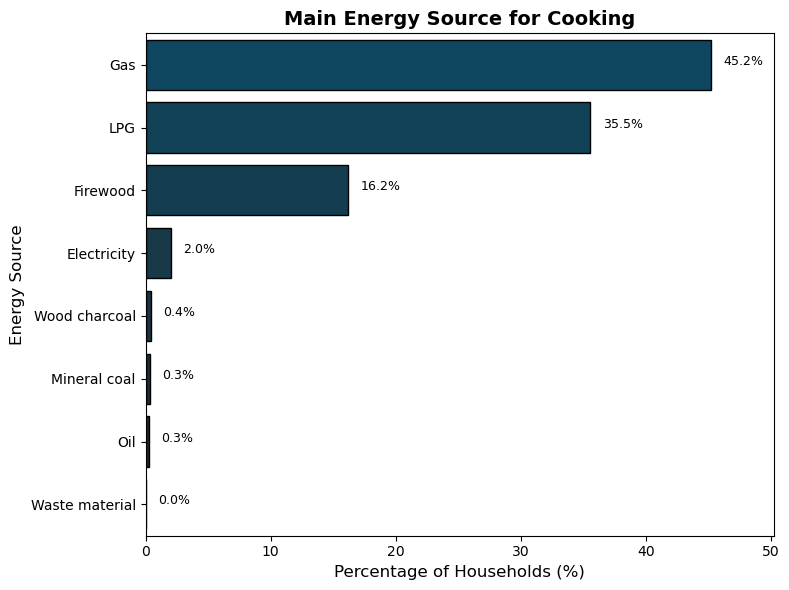

In [12]:
#The count of families was separated and normalized to observe the count in percentages
energy_cook_counts = db_main["energy_cook"].value_counts(normalize=True)*100
#The plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x=energy_cook_counts.values,
    y=energy_cook_counts.index,
    palette="dark:#004c6d_r",
    edgecolor="black")

#To improve the design of the percentages
for i, percent in enumerate(energy_cook_counts):
    plt.text(percent + 1, i, f"{percent:.1f}%", va='baseline', fontsize=9)

# Set x-axis limits. This line was searched on chat gpt in order to avoid cutting in the percentages
plt.xlim(0, energy_cook_counts.max() + 5)
# Labels and title
plt.title("Main Energy Source for Cooking", fontsize=14, fontweight='bold')
plt.xlabel("Percentage of Households (%)", fontsize=12)
plt.ylabel("Energy Source", fontsize=12)
plt.tight_layout()

plt.show()

To improve the analysis and deal with imbalances, the values will be renamed according to the classification of cooking fuels by WHO https://www.who.int/tools/clean-household-energy-solutions-toolkit/module-7-defining-clean
However, in the survey the value 4 corresponds to Oil, kerosene or alcohol being alcohol related to clean but kerosene as polluting. Thus following the paper <b>"Constrained cooking energy choices: Understanding up-the-ladder stacking behaviour in Dar es Salaam Tanzania" (Alananga and Igangula, 2022) </b> this category was assigned to transitional/polluting fuel. https://www.sciencedirect.com/science/article/pii/S0301421522003123?via%3Dihub
The value of LPG was assigned to "Clean fuel off-grid" since the objective is to analyze why families having access to the main grid choose to cook with other source.

<b>  WHO Cooking fuels classification </b>
<p align="center">
 <img align="left" width="600" height="600" src=https://cdn.who.int/media/images/default-source/air-pollution/air-quality-and-health/clean_technologies-for-cooking.png?sfvrsn alt="drawing"/>
</p>

In [13]:
# Create another column to reclassify the energy cooking sources
who = {'Electricity': 'Clean fuels',
    'Gas': 'Clean fuels',
    'Oil': 'Transitional/Polluting fuels',
    'LPG': 'Clean fuels off-grid',
    'Mineral coal': 'Transitional/Polluting fuels',
    'Firewood': 'Transitional/Polluting fuels',
    'Wood charcoal': 'Transitional/Polluting fuels',
    'Waste material': 'Transitional/Polluting fuels'}
db_main["who_fuel"] = db_main["energy_cook"].map(who)
db_main.head()

,house_code,family_code,gas,place_cook,energy_cook,PERCAPITA,people_count,urban,road_access,house_type,...,sewage,garbage,max_educ,min_age,max_age,fridge,stove,green_access,house_tenancy,who_fuel
0,7910114,1,True,kitchen,Gas,387500.0,2,True,Unpaved,house,...,True,True,High,16,43,True,True,10,Rent,Clean fuels
1,7910115,1,False,kitchen,Electricity,440000.0,5,False,Path_or_river,house,...,False,True,High,1,54,True,True,20,Collective,Clean fuels
2,7910119,1,False,kitchen,LPG,205000.0,2,False,Path_or_river,house,...,False,False,Secondary,57,77,True,True,25,Residency_no_payment,Clean fuels off-grid
3,7910120,1,False,kitchen,LPG,360000.0,2,False,Unpaved,house,...,False,False,Primary,64,65,True,True,10,Own,Clean fuels off-grid
4,7910121,1,False,kitchen,LPG,946250.0,2,True,Path_or_river,apartment,...,True,True,Technical,22,45,True,True,8,Own,Clean fuels off-grid


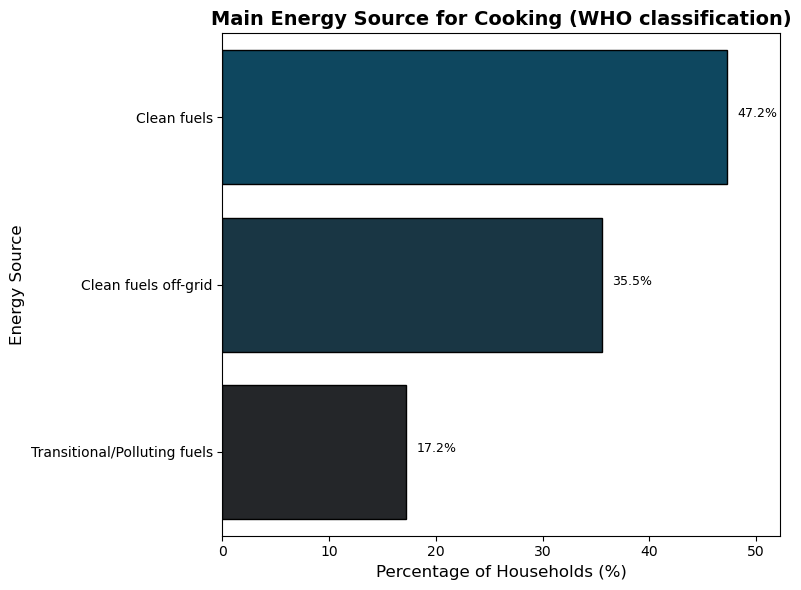

In [14]:
#The previous code to plot the cooking fuels was used againg after the clasification
who_cook_counts = db_main["who_fuel"].value_counts(normalize=True)*100
#The plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x=who_cook_counts.values,
    y=who_cook_counts.index,
    palette="dark:#004c6d_r",
    edgecolor="black")

#To improve the design of the percentages
for i, percent in enumerate(who_cook_counts):
    plt.text(percent + 1, i, f"{percent:.1f}%", va='baseline', fontsize=9)

# Set x-axis limits. This line was searched on chat gpt in order to avoid cutting in the percentages
plt.xlim(0, who_cook_counts.max() + 5)
# Labels and title
plt.title("Main Energy Source for Cooking (WHO classification)", fontsize=14, fontweight='bold')
plt.xlabel("Percentage of Households (%)", fontsize=12)
plt.ylabel("Energy Source", fontsize=12)
plt.tight_layout()

plt.show()

## Numeric Variables
The following lines will explore the numeric data and deal with outliers.

In [15]:
# I excluded the ID codes since they're numeric but will not be used in the models
columns_to_exclude = ['house_code','family_code','energy_cook','gas','energy']
db_main= db_main.drop(columns=columns_to_exclude, errors='ignore')
numeric_data = db_main.select_dtypes(include=[np.number])
numeric_data.describe()

,PERCAPITA,people_count,min_age,max_age,green_access
count,8.029400e+04,80294.000000,80294.000000,80294.000000,80294.000000
mean,9.338722e+05,2.822141,28.164595,52.353364,23.709879
std,2.080052e+06,1.497298,23.920752,17.085479,103.484982
min,0.000000e+00,1.000000,0.000000,15.000000,0.000000
25%,2.873750e+05,2.000000,8.000000,39.000000,2.000000
50%,5.166667e+05,3.000000,20.000000,52.000000,5.000000
75%,9.811528e+05,4.000000,49.000000,65.000000,15.000000
max,2.500000e+08,24.000000,100.000000,104.000000,999.000000


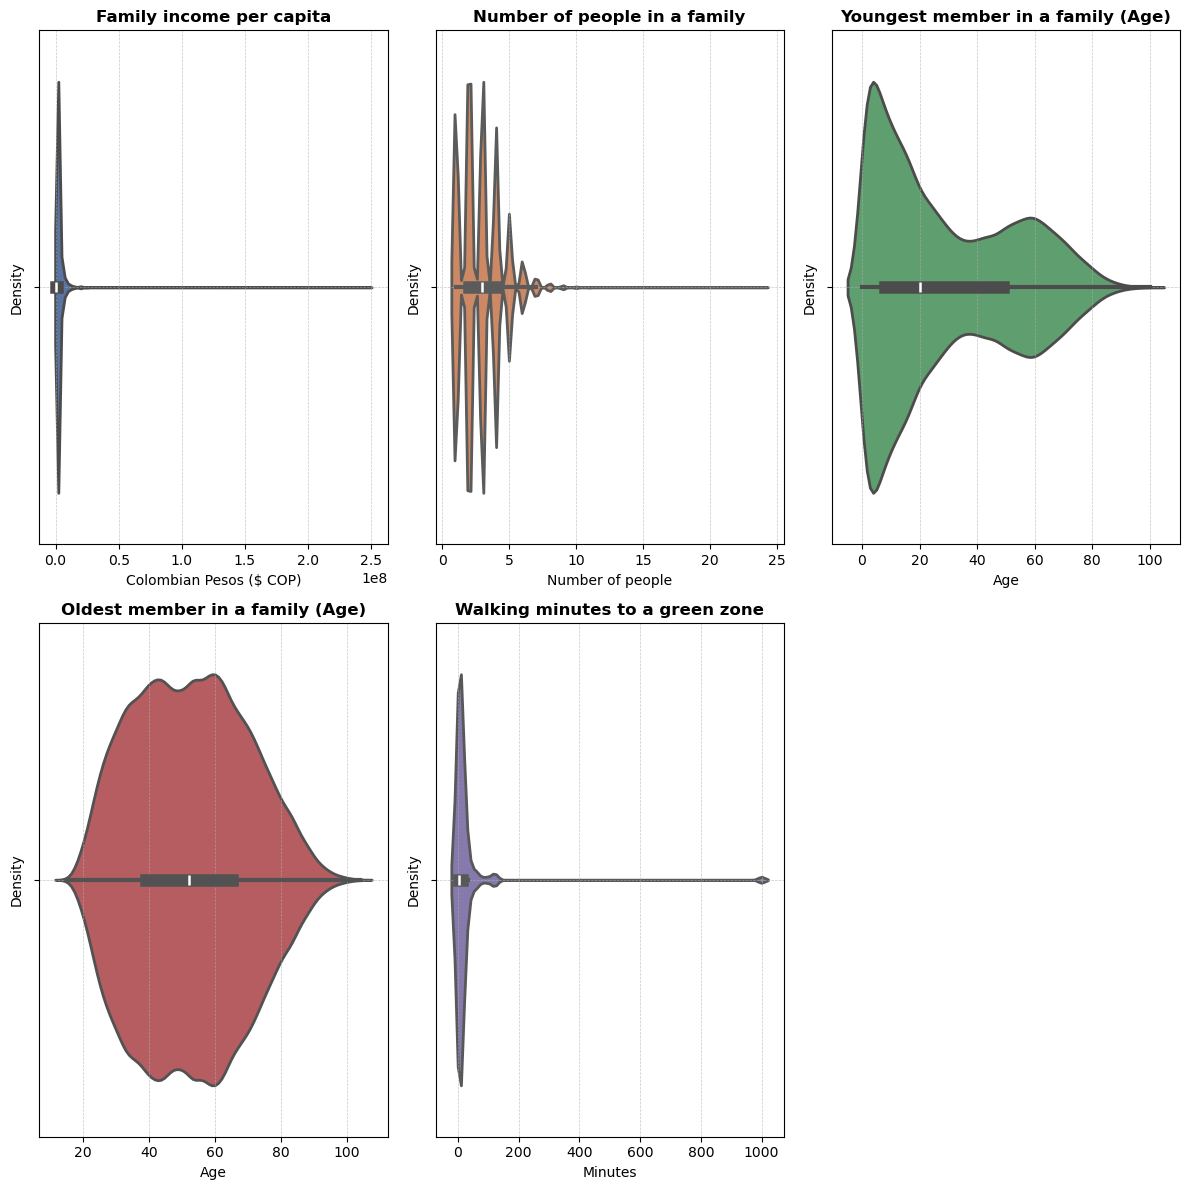

In [16]:
#I plotted the numeric variables with a violin plot to observe the distribution and boxplot 
fig, axes = plt.subplots(2, 3, figsize=(12, 12))
axes = axes.flatten()  # Flatten the axes array for easier indexing
plot_palette = sns.color_palette("deep", n_colors=5)

# I defined the titles and value labels for each subplot. This line of code I extracted from Chat GPT
titles = ["Family income per capita", 
    "Number of people in a family", 
    "Youngest member in a family (Age)", 
    "Oldest member in a family (Age)", 
    "Walking minutes to a green zone"]
x_labels = ["Colombian Pesos ($ COP)", 
    "Number of people", 
    "Age", 
    "Age", 
    "Minutes"]

# Next, with a loop I create the violin plots, lines extracted from chat GPT
for i, column in enumerate(numeric_data.columns):
    sns.violinplot(x=numeric_data[column], ax=axes[i], 
        palette=[plot_palette[i]],  # to have different colors in each subplot
        linewidth=2, width=0.8)
    axes[i].set_title(titles[i], fontsize=12, weight='bold')
    axes[i].set_xlabel(x_labels[i], fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Remove unused axes (if any) (this line was searched on chat GPT to improve the design of the plot removing the additional subplot)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

It is noted some extreme values in <b> PERCAPITA </b> and <b> green_access </b>. For the <b> green_access </b> variable, it was noted that the maximum values is 999 but there no intermediate values between 120 and 999 which highlight some inconsistencies in this variable. I could not find any explanation of the 999 value in the official page of the National Statistics deparment therefore, those families with 999 value in <b> green_access </b> were discarded.

In [17]:
outlier = db_main[db_main["green_access"] == 999].shape[0]
print(outlier)

855


Since, they're only 855 families (1% of the total families) with that value, they were discarded.

In [18]:
db_main=db_main[db_main["green_access"]!=999]
db_main

,place_cook,PERCAPITA,people_count,urban,road_access,house_type,water,sewage,garbage,max_educ,min_age,max_age,fridge,stove,green_access,house_tenancy,who_fuel
0,kitchen,3.875000e+05,2,True,Unpaved,house,True,True,True,High,16,43,True,True,10,Rent,Clean fuels
1,kitchen,4.400000e+05,5,False,Path_or_river,house,True,False,True,High,1,54,True,True,20,Collective,Clean fuels
2,kitchen,2.050000e+05,2,False,Path_or_river,house,True,False,False,Secondary,57,77,True,True,25,Residency_no_payment,Clean fuels off-grid
3,kitchen,3.600000e+05,2,False,Unpaved,house,True,False,False,Primary,64,65,True,True,10,Own,Clean fuels off-grid
4,kitchen,9.462500e+05,2,True,Path_or_river,apartment,True,True,True,Technical,22,45,True,True,8,Own,Clean fuels off-grid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,kitchen,3.416667e+05,2,True,Paved,house,True,True,True,Secondary,5,44,True,True,5,Rent,Clean fuels
86401,Outside,1.633333e+05,3,False,Sidewalk,house,True,False,False,High,3,25,True,True,0,Collective,Clean fuels off-grid
86402,kitchen,1.025000e+06,2,False,Paved,house,True,True,True,High,5,46,True,True,20,Own,Clean fuels
86403,kitchen,2.850000e+06,1,False,Paved,house,True,True,True,Secondary,63,63,True,True,20,Residency_no_payment,Clean fuels off-grid


For the variable <b> PERCAPITA </b> a transofrmation to categorical was used in order to classify the families by the monetary poverty classification according to the Department of National Statistics (DANE) based on the monthly income percapita  https://www.dane.gov.co/index.php/estadisticas-por-tema/pobreza-y-condiciones-de-vida/pobreza-monetaria

- **Poor**: From ``$0`` to ``$435,375``
- **Vulnerable**: From ``$435,376`` to ``$853,608``
- **Middle income**: From ``$853,609`` to ``$4,596,352``
- **High income**: More than ``$4,596,352``

In [19]:
# Categorize 'PERCAPITA' into economic classes
db_main['economic_class'] = pd.cut(
    db_main['PERCAPITA'],
    bins=[-float('inf'), 435375, 853608, 4596352, float('inf')],
    labels=["Poor", "Vulnerable", "Middle", "High"]).astype(object)
db_main

,place_cook,PERCAPITA,people_count,urban,road_access,house_type,water,sewage,garbage,max_educ,min_age,max_age,fridge,stove,green_access,house_tenancy,who_fuel,economic_class
0,kitchen,3.875000e+05,2,True,Unpaved,house,True,True,True,High,16,43,True,True,10,Rent,Clean fuels,Poor
1,kitchen,4.400000e+05,5,False,Path_or_river,house,True,False,True,High,1,54,True,True,20,Collective,Clean fuels,Vulnerable
2,kitchen,2.050000e+05,2,False,Path_or_river,house,True,False,False,Secondary,57,77,True,True,25,Residency_no_payment,Clean fuels off-grid,Poor
3,kitchen,3.600000e+05,2,False,Unpaved,house,True,False,False,Primary,64,65,True,True,10,Own,Clean fuels off-grid,Poor
4,kitchen,9.462500e+05,2,True,Path_or_river,apartment,True,True,True,Technical,22,45,True,True,8,Own,Clean fuels off-grid,Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,kitchen,3.416667e+05,2,True,Paved,house,True,True,True,Secondary,5,44,True,True,5,Rent,Clean fuels,Poor
86401,Outside,1.633333e+05,3,False,Sidewalk,house,True,False,False,High,3,25,True,True,0,Collective,Clean fuels off-grid,Poor
86402,kitchen,1.025000e+06,2,False,Paved,house,True,True,True,High,5,46,True,True,20,Own,Clean fuels,Middle
86403,kitchen,2.850000e+06,1,False,Paved,house,True,True,True,Secondary,63,63,True,True,20,Residency_no_payment,Clean fuels off-grid,Middle


In [20]:
# After the transformation, I excluded the percapita income
columns_to_exclude = ['PERCAPITA']
db_main = db_main.drop(columns=columns_to_exclude, errors='ignore')
db_main

,place_cook,people_count,urban,road_access,house_type,water,sewage,garbage,max_educ,min_age,max_age,fridge,stove,green_access,house_tenancy,who_fuel,economic_class
0,kitchen,2,True,Unpaved,house,True,True,True,High,16,43,True,True,10,Rent,Clean fuels,Poor
1,kitchen,5,False,Path_or_river,house,True,False,True,High,1,54,True,True,20,Collective,Clean fuels,Vulnerable
2,kitchen,2,False,Path_or_river,house,True,False,False,Secondary,57,77,True,True,25,Residency_no_payment,Clean fuels off-grid,Poor
3,kitchen,2,False,Unpaved,house,True,False,False,Primary,64,65,True,True,10,Own,Clean fuels off-grid,Poor
4,kitchen,2,True,Path_or_river,apartment,True,True,True,Technical,22,45,True,True,8,Own,Clean fuels off-grid,Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,kitchen,2,True,Paved,house,True,True,True,Secondary,5,44,True,True,5,Rent,Clean fuels,Poor
86401,Outside,3,False,Sidewalk,house,True,False,False,High,3,25,True,True,0,Collective,Clean fuels off-grid,Poor
86402,kitchen,2,False,Paved,house,True,True,True,High,5,46,True,True,20,Own,Clean fuels,Middle
86403,kitchen,1,False,Paved,house,True,True,True,Secondary,63,63,True,True,20,Residency_no_payment,Clean fuels off-grid,Middle


As seen during the term, deal with skewness could enhance the robustness of the model. Therefore, the code used in the lab sessions to review which of the numeric variables are skewed, either negative or positive, in order to correct them.

In [21]:
from scipy.stats import skew
numeric_data=db_main.select_dtypes(include=[np.number])

skewed = db_main[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))

# these are all the variables that are very positively skewed. 
rskewed = skewed[(skewed > 1)].index

# these are all the variables that are very negatively skewed. 
lskewed = skewed[(skewed < -1)].index
print (f'leftskewed:{lskewed} and right-skewed:{rskewed}')


leftskewed:Index([], dtype='object') and right-skewed:Index(['people_count', 'green_access'], dtype='object')


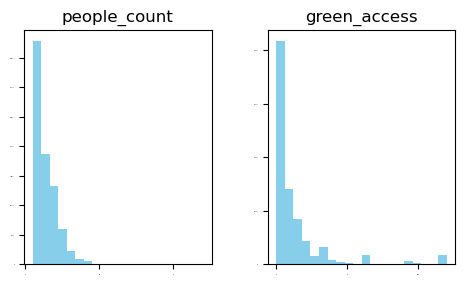

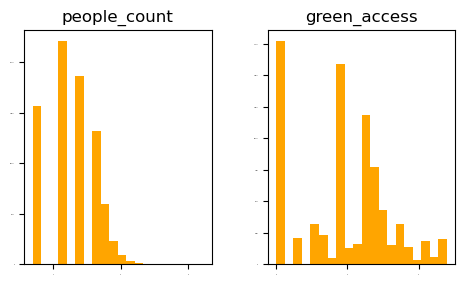

In [22]:
# Graph the variables before and after the transformation plot. Since there are no left skewed the transformation was only on the right skewed
db_main[rskewed].hist(bins=20,figsize=(15,7), color='skyblue', xlabelsize=0, ylabelsize=0, grid=False, layout=(2,5))
plt.show()
db_main[rskewed] = np.log1p(db_main[rskewed])
# then I plot again the variables after their log transformation
db_main[rskewed].hist(bins=20,figsize=(15,7), color='orange', xlabelsize=0, ylabelsize=0, grid=False, layout=(2,5))
plt.show()

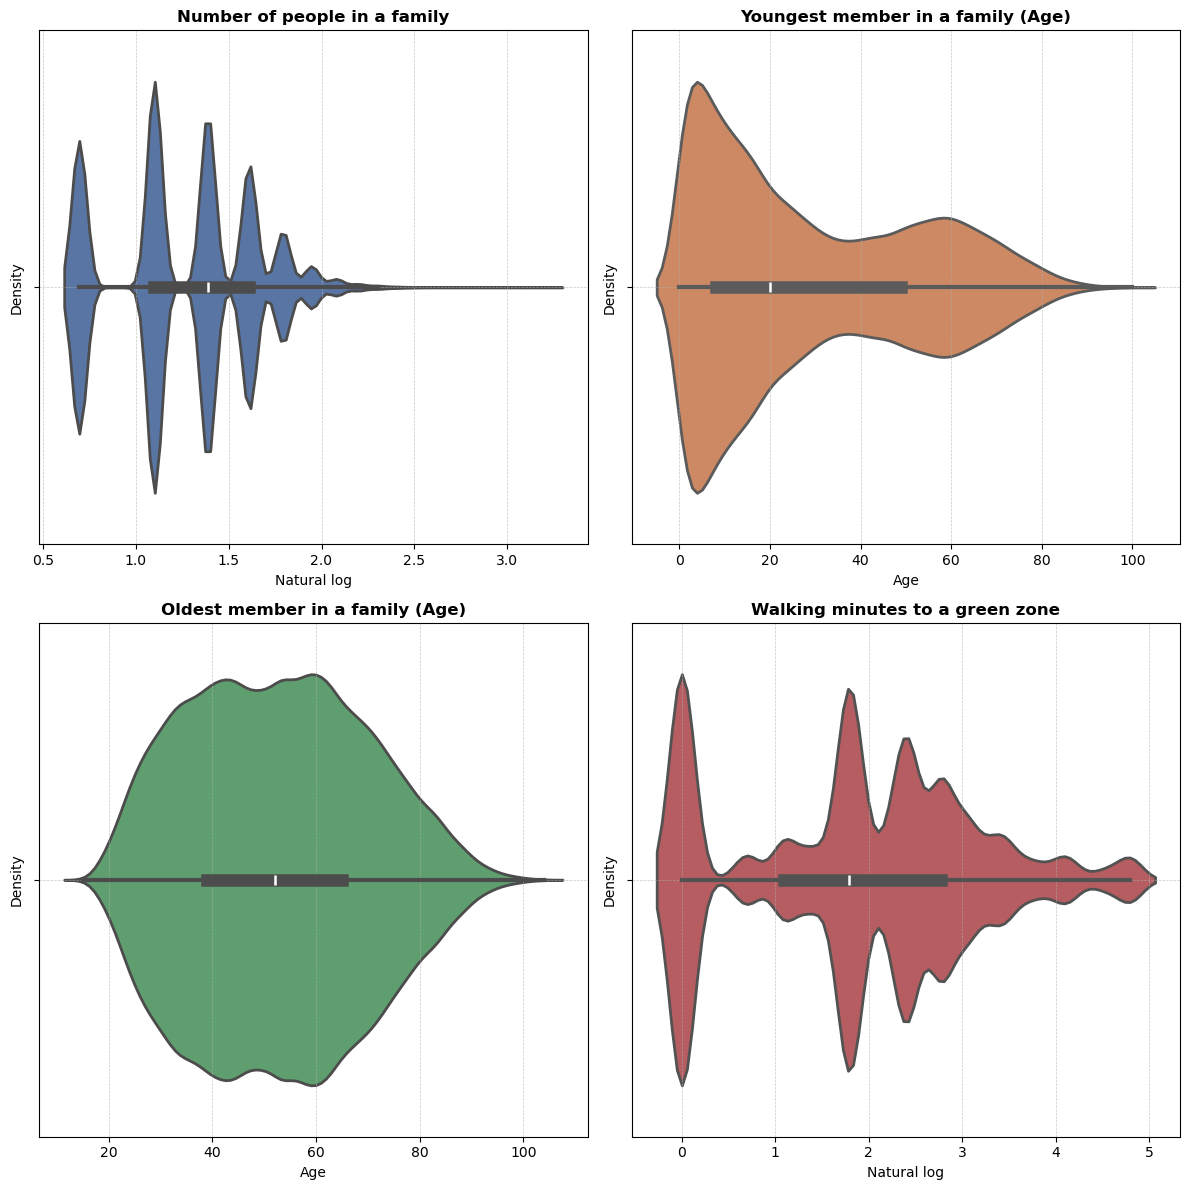

In [23]:
#the same violin plot but after the transformation of PERCAPITA and the dropping of the value 999 in green_access
numeric_data = db_main.select_dtypes(include=[np.number])
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten the axes array for easier indexing
plot_palette = sns.color_palette("deep", n_colors=4)

# I defined the titles and value labels for each subplot
titles = [ "Number of people in a family", 
    "Youngest member in a family (Age)", 
    "Oldest member in a family (Age)", 
    "Walking minutes to a green zone"]
x_labels = [ "Natural log", 
    "Age", 
    "Age", 
    "Natural log"]

# Next, with a loop I create the violin plots
for i, column in enumerate(numeric_data.columns):
    sns.violinplot(x=numeric_data[column], ax=axes[i], 
        palette=[plot_palette[i]],  # to have different colors in each subplot
        linewidth=2, width=0.8)
    axes[i].set_title(titles[i], fontsize=12, weight='bold')
    axes[i].set_xlabel(x_labels[i], fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Remove unused axes (if any) (this line was searched on chat GPT to improve the design of the plot removing the additional subplot)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'people_count'),
  Text(0, 1.5, 'min_age'),
  Text(0, 2.5, 'max_age'),
  Text(0, 3.5, 'green_access')])

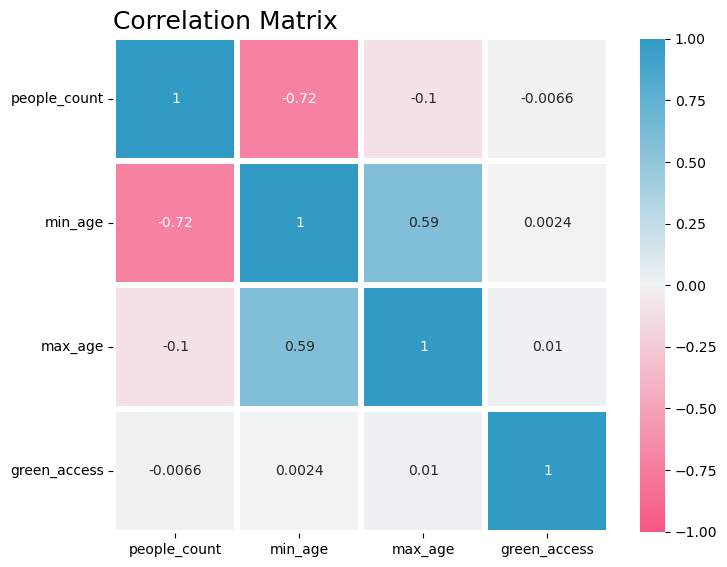

In [24]:
#Correlation between the numeric variables
# Compute the correlation matrix
corr = numeric_data.corr()
# Set up the matplotlib figure
plt.figure(figsize=(8,8))
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True) 

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1, cmap=cmap, vmin=-1, center=0, annot=True,
            square=True, linewidths=3, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', loc='left', fontsize=18)
plt.yticks(rotation=0)

Due to min_age is highly correlated with people_count and max_age, it was decided to drop the min_age.

In [25]:
columns_to_exclude = ['min_age']
db_main = db_main.drop(columns=columns_to_exclude, errors='ignore')
db_main

,place_cook,people_count,urban,road_access,house_type,water,sewage,garbage,max_educ,max_age,fridge,stove,green_access,house_tenancy,who_fuel,economic_class
0,kitchen,1.098612,True,Unpaved,house,True,True,True,High,43,True,True,2.397895,Rent,Clean fuels,Poor
1,kitchen,1.791759,False,Path_or_river,house,True,False,True,High,54,True,True,3.044522,Collective,Clean fuels,Vulnerable
2,kitchen,1.098612,False,Path_or_river,house,True,False,False,Secondary,77,True,True,3.258097,Residency_no_payment,Clean fuels off-grid,Poor
3,kitchen,1.098612,False,Unpaved,house,True,False,False,Primary,65,True,True,2.397895,Own,Clean fuels off-grid,Poor
4,kitchen,1.098612,True,Path_or_river,apartment,True,True,True,Technical,45,True,True,2.197225,Own,Clean fuels off-grid,Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,kitchen,1.098612,True,Paved,house,True,True,True,Secondary,44,True,True,1.791759,Rent,Clean fuels,Poor
86401,Outside,1.386294,False,Sidewalk,house,True,False,False,High,25,True,True,0.000000,Collective,Clean fuels off-grid,Poor
86402,kitchen,1.098612,False,Paved,house,True,True,True,High,46,True,True,3.044522,Own,Clean fuels,Middle
86403,kitchen,0.693147,False,Paved,house,True,True,True,Secondary,63,True,True,3.044522,Residency_no_payment,Clean fuels off-grid,Middle


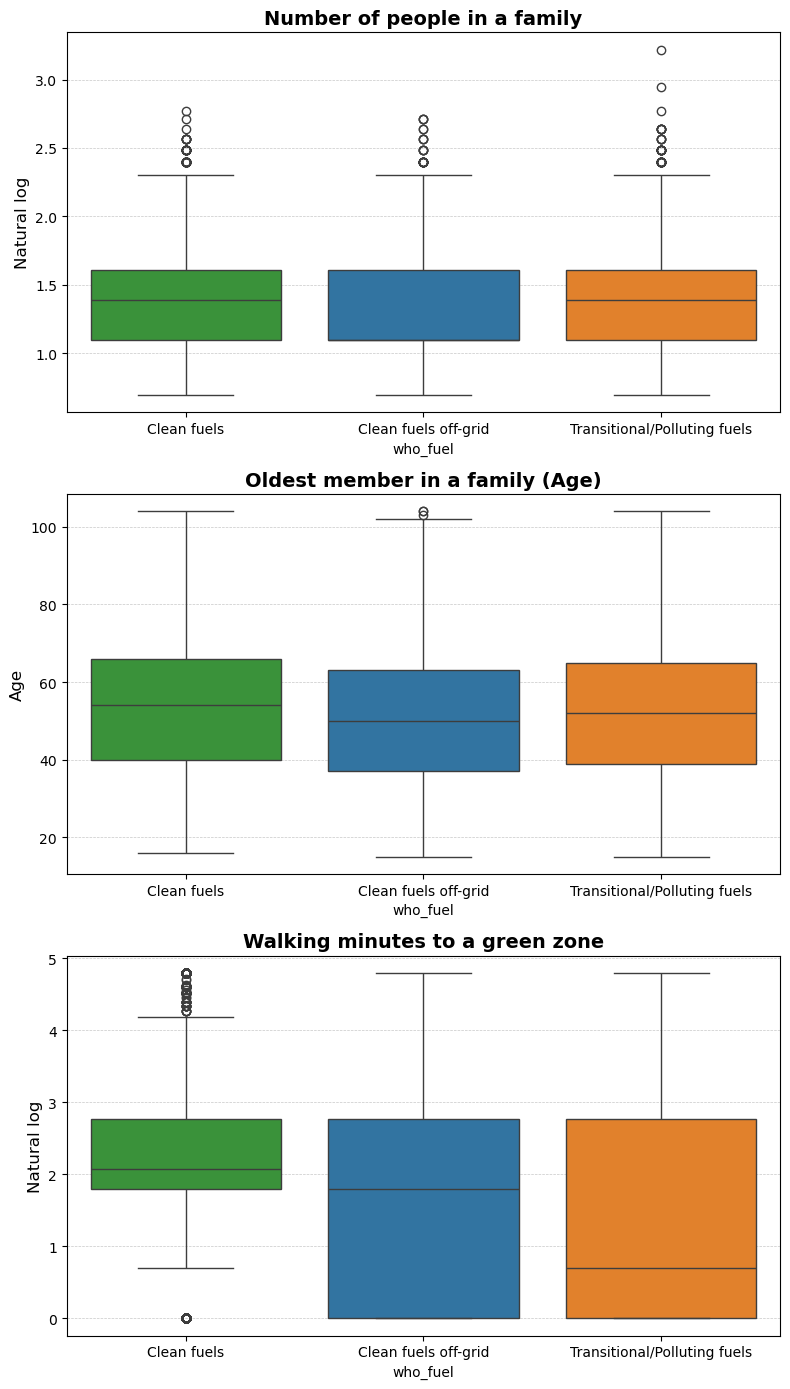

In [26]:
# Prepare the layout for the subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 14))
axes = axes.flatten()
numeric_data = db_main.select_dtypes(include=[np.number])
titles = [ "Number of people in a family", 
    "Oldest member in a family (Age)", 
    "Walking minutes to a green zone"]
x_labels = [ "Natural log", 
    "Age",  
    "Natural log"]
# Loop through each numerical variable (this lines was based on the previous lines in which I iterated)
for idx, column in enumerate(numeric_data.columns):
    sns.boxplot(data=db_main, 
        x="who_fuel", 
        y=column, 
        ax=axes[idx], 
        palette=["#2CA02C","#1F77B4","#FF7F0E"])
    axes[idx].set_title(titles[idx], fontsize=14, weight="bold")
    axes[idx].set_ylabel(x_labels[idx], fontsize=12)  # Use y_labels for y-axis labels
    axes[idx].grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
    axes[idx].tick_params(axis="x", rotation=0)  # Rotate x-axis labels for clarity

plt.tight_layout()
plt.show()


In [27]:
#With the aid of chat GPT I did these lines of code to test variance in each numeric variable among the groups of cooking fuel
#The prompt was "how to make the anova test in each numerical variable categorized by who_fuel?"
from scipy.stats import f_oneway

# Prepare a dictionary to store ANOVA results
anova_results = {}

# Loop through each numerical variable
for column in numeric_data.columns:
    # Group the data by 'who_fuel' and extract values for each group
    groups = [group[column].values for name, group in db_main.groupby('who_fuel')]
    
    # Perform the ANOVA test
    f_stat, p_value = f_oneway(*groups)
    
    # Store the results in the dictionary
    anova_results[column] = {'F-statistic': f_stat, 'p-value': p_value}

# Display results
for variable, results in anova_results.items():
    print(f"Variable: {variable}")
    print(f"  F-statistic: {results['F-statistic']:.4f}")
    print(f"  p-value: {results['p-value']:.4e}")
    print("  Significant difference among groups:" + 
          (" Yes" if results['p-value'] < 0.05 else " No"))
    print()

Variable: people_count
  F-statistic: 198.0525
  p-value: 1.5872e-86
  Significant difference among groups: Yes

Variable: max_age
  F-statistic: 299.9530
  p-value: 1.6654e-130
  Significant difference among groups: Yes

Variable: green_access
  F-statistic: 953.3124
  p-value: 0.0000e+00
  Significant difference among groups: Yes



## Categorical variables
The next lines of code will explore the categorical variables, encoding them and propose feature engineering to some of them

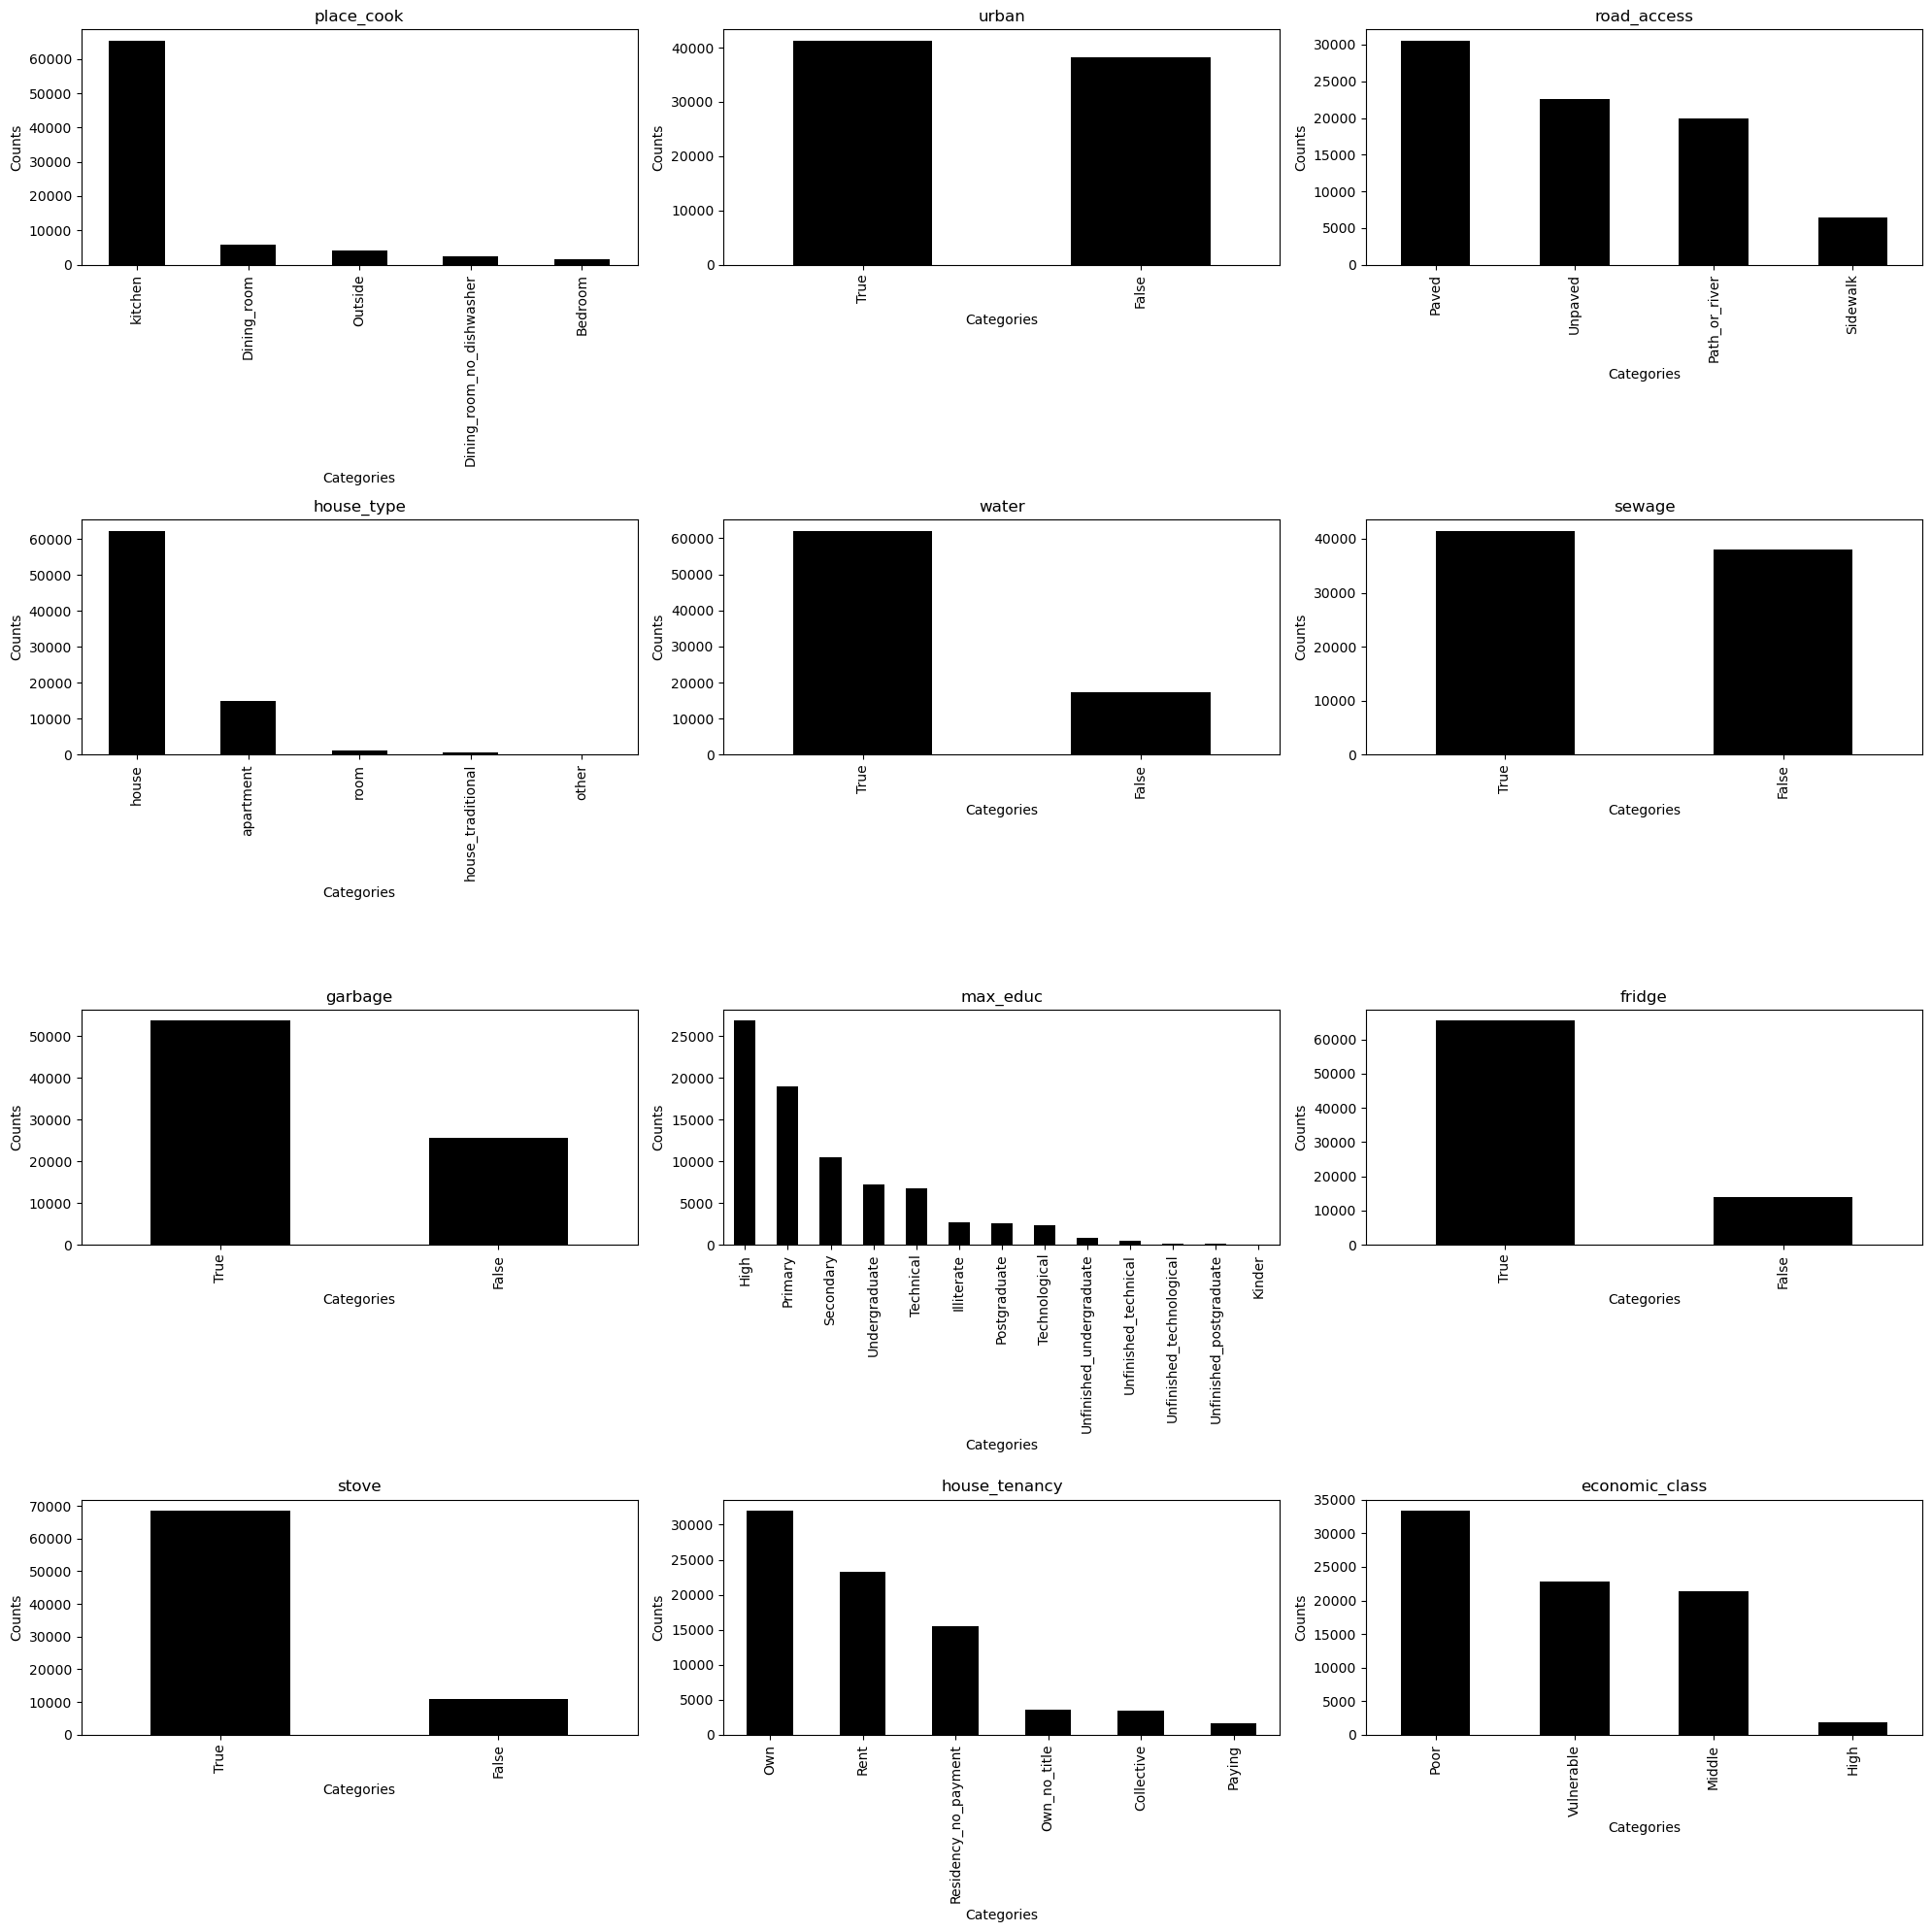

In [28]:
# I filtered the categorical columns
categorical_data = db_main.select_dtypes(include=[object,bool]).drop(columns="who_fuel")
#Plot
num_columns = len(categorical_data.columns)
num_rows = (num_columns + 2) // 3 
fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
axes = axes.flatten()
#Loop for each categorical variable to create the subplots
for idx, col in enumerate(categorical_data.columns):
    categorical_data[col].value_counts().plot(
        kind='bar',
        color='black',
        ax=axes[idx],
        title=col
    )
    axes[idx].set_xlabel("Categories")
    axes[idx].set_ylabel("Counts")

for idx in range(num_columns, len(axes)):
    axes[idx].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

The variable <b> place_cook </b> has a imbalance since the majority of the sample cooks in the kitchen and the other rooms have less concentration of families. Therefore, this variable is transformed to <b> kitchen </b> a boolean in which True means if the family cook in the kitchen otherwise in other rooms.

<b> max_educ </b> will be grouped into four categories Illiterate, primary, secondary and tertiary.Another change is in the variable <b> house_tenancy </b> due to the interest with this feature is to analyze if the family is paying through a mortgage or rent for living in a house therefore a reclassification was made based on this interest. Same with <b> house_type </b> since it has a low distribution in the values of room, traditional house and others, thus they were grouped in others referencing to other types of habitat apart from house and apartment. These changes were made according to the article <b> Towards Use of Cleaner Fuels in Urban and Rural Households in Colombia: Empirical Evidence from 2010 to 2016 </b> by PÉREZ, J., BERNAL, E. & RODRÍGUEZ-SÁNCHEZ (2021).  https://journals.sagepub.com/doi/abs/10.5547/01956574.42.5.jper


In [29]:
# I created a dictionary for all the reclassifications
reclassification_mappings = {'house_tenancy': {'Own': 'Own/No payment',
        'Own_no_title': 'Own/No payment',
        'Residency_no_payment': 'Own/No payment',
        'Paying': 'Rent/Mortgage',
        'Rent': 'Rent/Mortgage',
        'Collective': 'Collective'},
    'house_type': {'house': 'house',
        'apartment': 'apartment',
        'house_traditional': 'others',
        'room': 'others',
        'other': 'others'},
    'max_educ': {"Illiterate": "Illiterate",
        "Kinder": "Primary",
        "Primary": "Primary",
        "Secondary": "Secondary",
        "High": "Secondary",
        "Unfinished_technical": "Tertiary",
        "Technical": "Tertiary",
        "Unfinished_technological": "Tertiary",
        "Technological": "Tertiary",
        "Unfinished_undergraduate": "Tertiary",
        "Undergraduate": "Tertiary",
        "Unfinished_postgraduate": "Tertiary",
        "Postgraduate": "Tertiary"}}

# Apply mapping
for column, mapping in reclassification_mappings.items():
    db_main[column] = db_main[column].map(mapping)

# For place_cook I created a boolean column for kitchen
db_main['kitchen'] = db_main['place_cook'] == 'kitchen'

# Drop the 'place_cook' column
db_main.drop(columns='place_cook', inplace=True)
db_main

,people_count,urban,road_access,house_type,water,sewage,garbage,max_educ,max_age,fridge,stove,green_access,house_tenancy,who_fuel,economic_class,kitchen
0,1.098612,True,Unpaved,house,True,True,True,Secondary,43,True,True,2.397895,Rent/Mortgage,Clean fuels,Poor,True
1,1.791759,False,Path_or_river,house,True,False,True,Secondary,54,True,True,3.044522,Collective,Clean fuels,Vulnerable,True
2,1.098612,False,Path_or_river,house,True,False,False,Secondary,77,True,True,3.258097,Own/No payment,Clean fuels off-grid,Poor,True
3,1.098612,False,Unpaved,house,True,False,False,Primary,65,True,True,2.397895,Own/No payment,Clean fuels off-grid,Poor,True
4,1.098612,True,Path_or_river,apartment,True,True,True,Tertiary,45,True,True,2.197225,Own/No payment,Clean fuels off-grid,Middle,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,1.098612,True,Paved,house,True,True,True,Secondary,44,True,True,1.791759,Rent/Mortgage,Clean fuels,Poor,True
86401,1.386294,False,Sidewalk,house,True,False,False,Secondary,25,True,True,0.000000,Collective,Clean fuels off-grid,Poor,False
86402,1.098612,False,Paved,house,True,True,True,Secondary,46,True,True,3.044522,Own/No payment,Clean fuels,Middle,True
86403,0.693147,False,Paved,house,True,True,True,Secondary,63,True,True,3.044522,Own/No payment,Clean fuels off-grid,Middle,True


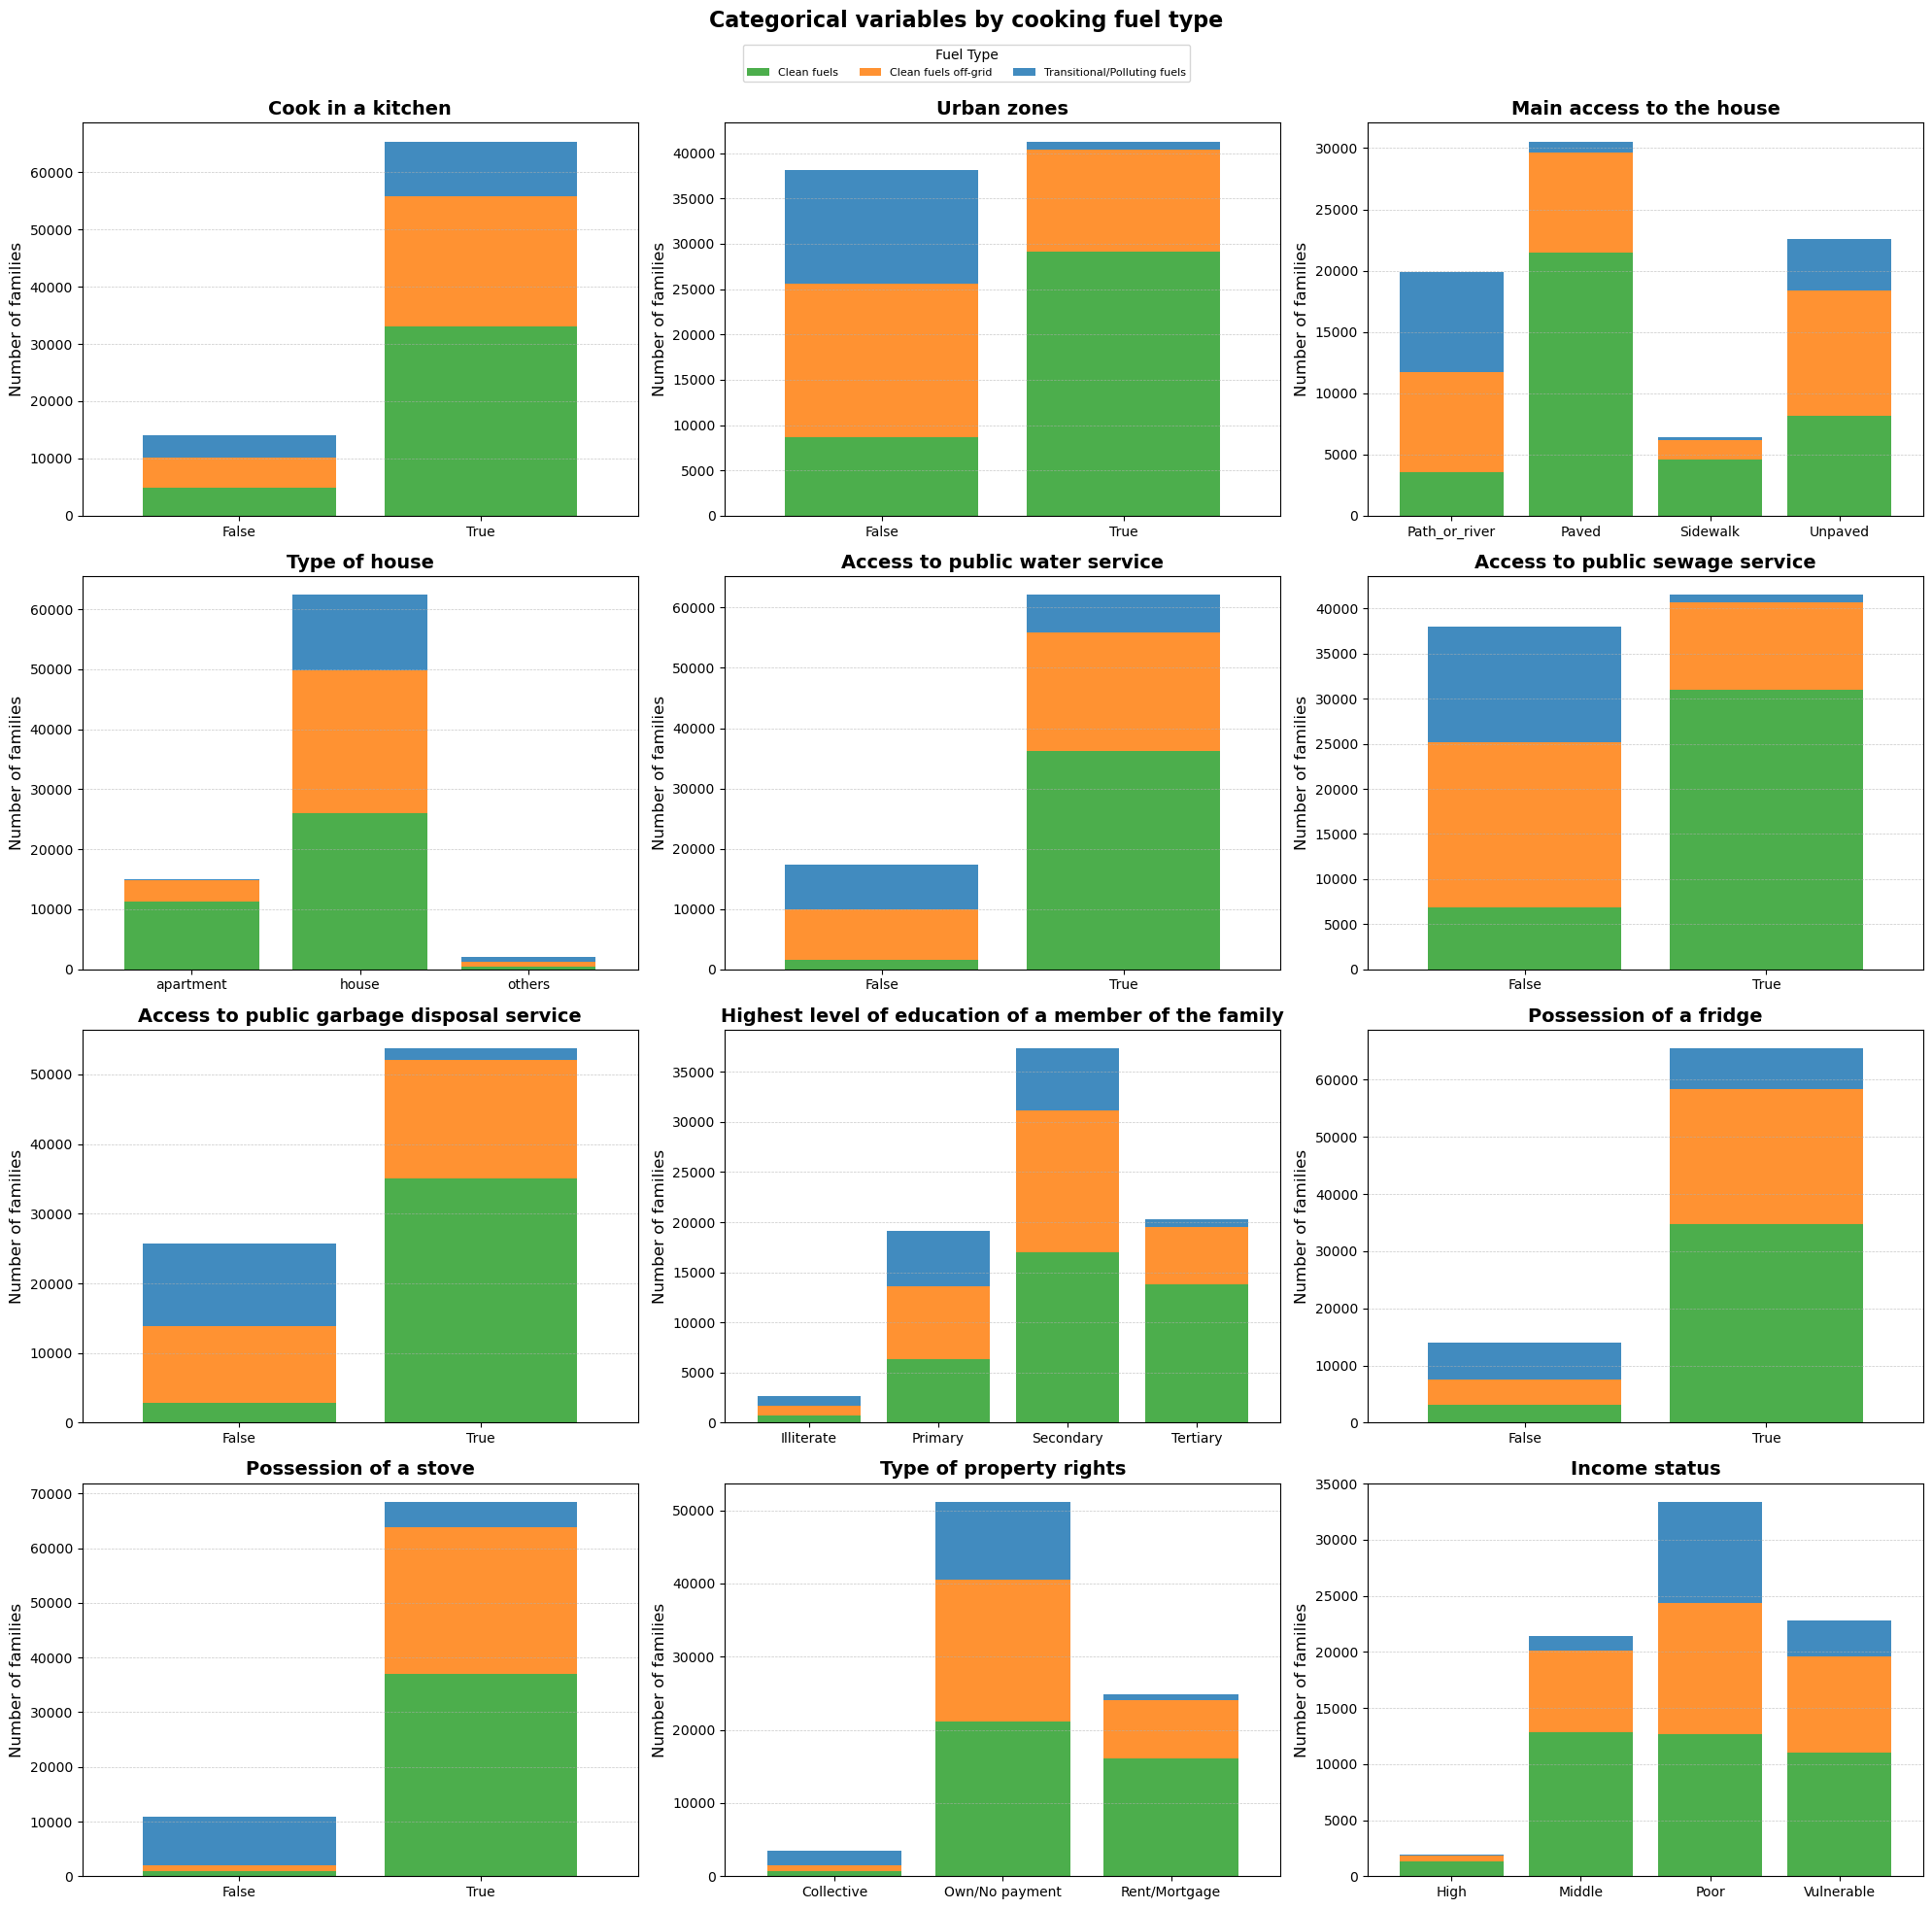

In [30]:
#### List of categorical variables with titles in order to personalize each subplot
categorical_variables = {"kitchen": "Cook in a kitchen",
    "urban": "Urban zones",
    "road_access": "Main access to the house",
    "house_type": "Type of house",
    "water": "Access to public water service",
    "sewage": "Access to public sewage service",
    "garbage": "Access to public garbage disposal service",
    "max_educ": "Highest level of education of a member of the family",
    "fridge": "Possession of a fridge",
    "stove": "Possession of a stove",
    "house_tenancy": "Type of property rights",
    "economic_class": "Income status"}
fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten to make it easier to access each axis
# Loop through each categorical variable
for idx, (column, title) in enumerate(categorical_variables.items()):
    crosstab = pd.crosstab(db_main[column], db_main['who_fuel'])
    crosstab.plot(kind='bar',
        stacked=True,
        ax=axes[idx],
        color=[ "#2CA02C","#FF7F0E","#1F77B4"],  # Same as the boxplot in the numeric variable
        alpha=0.85,
        width=0.8, legend=False)  
    axes[idx].set_title(title, fontsize=14, weight="bold")
    axes[idx].set_xlabel("")  
    axes[idx].set_ylabel("Number of families", fontsize=12)  
    axes[idx].tick_params(axis="x", rotation=0, labelsize=10)
    axes[idx].grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
#To insert a title for all the plot
handles, labels = axes[0].get_legend_handles_labels()  
fig.legend(handles, labels, title="Fuel Type", loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 0.965), ncol=3)
plt.suptitle("Categorical variables by cooking fuel type", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

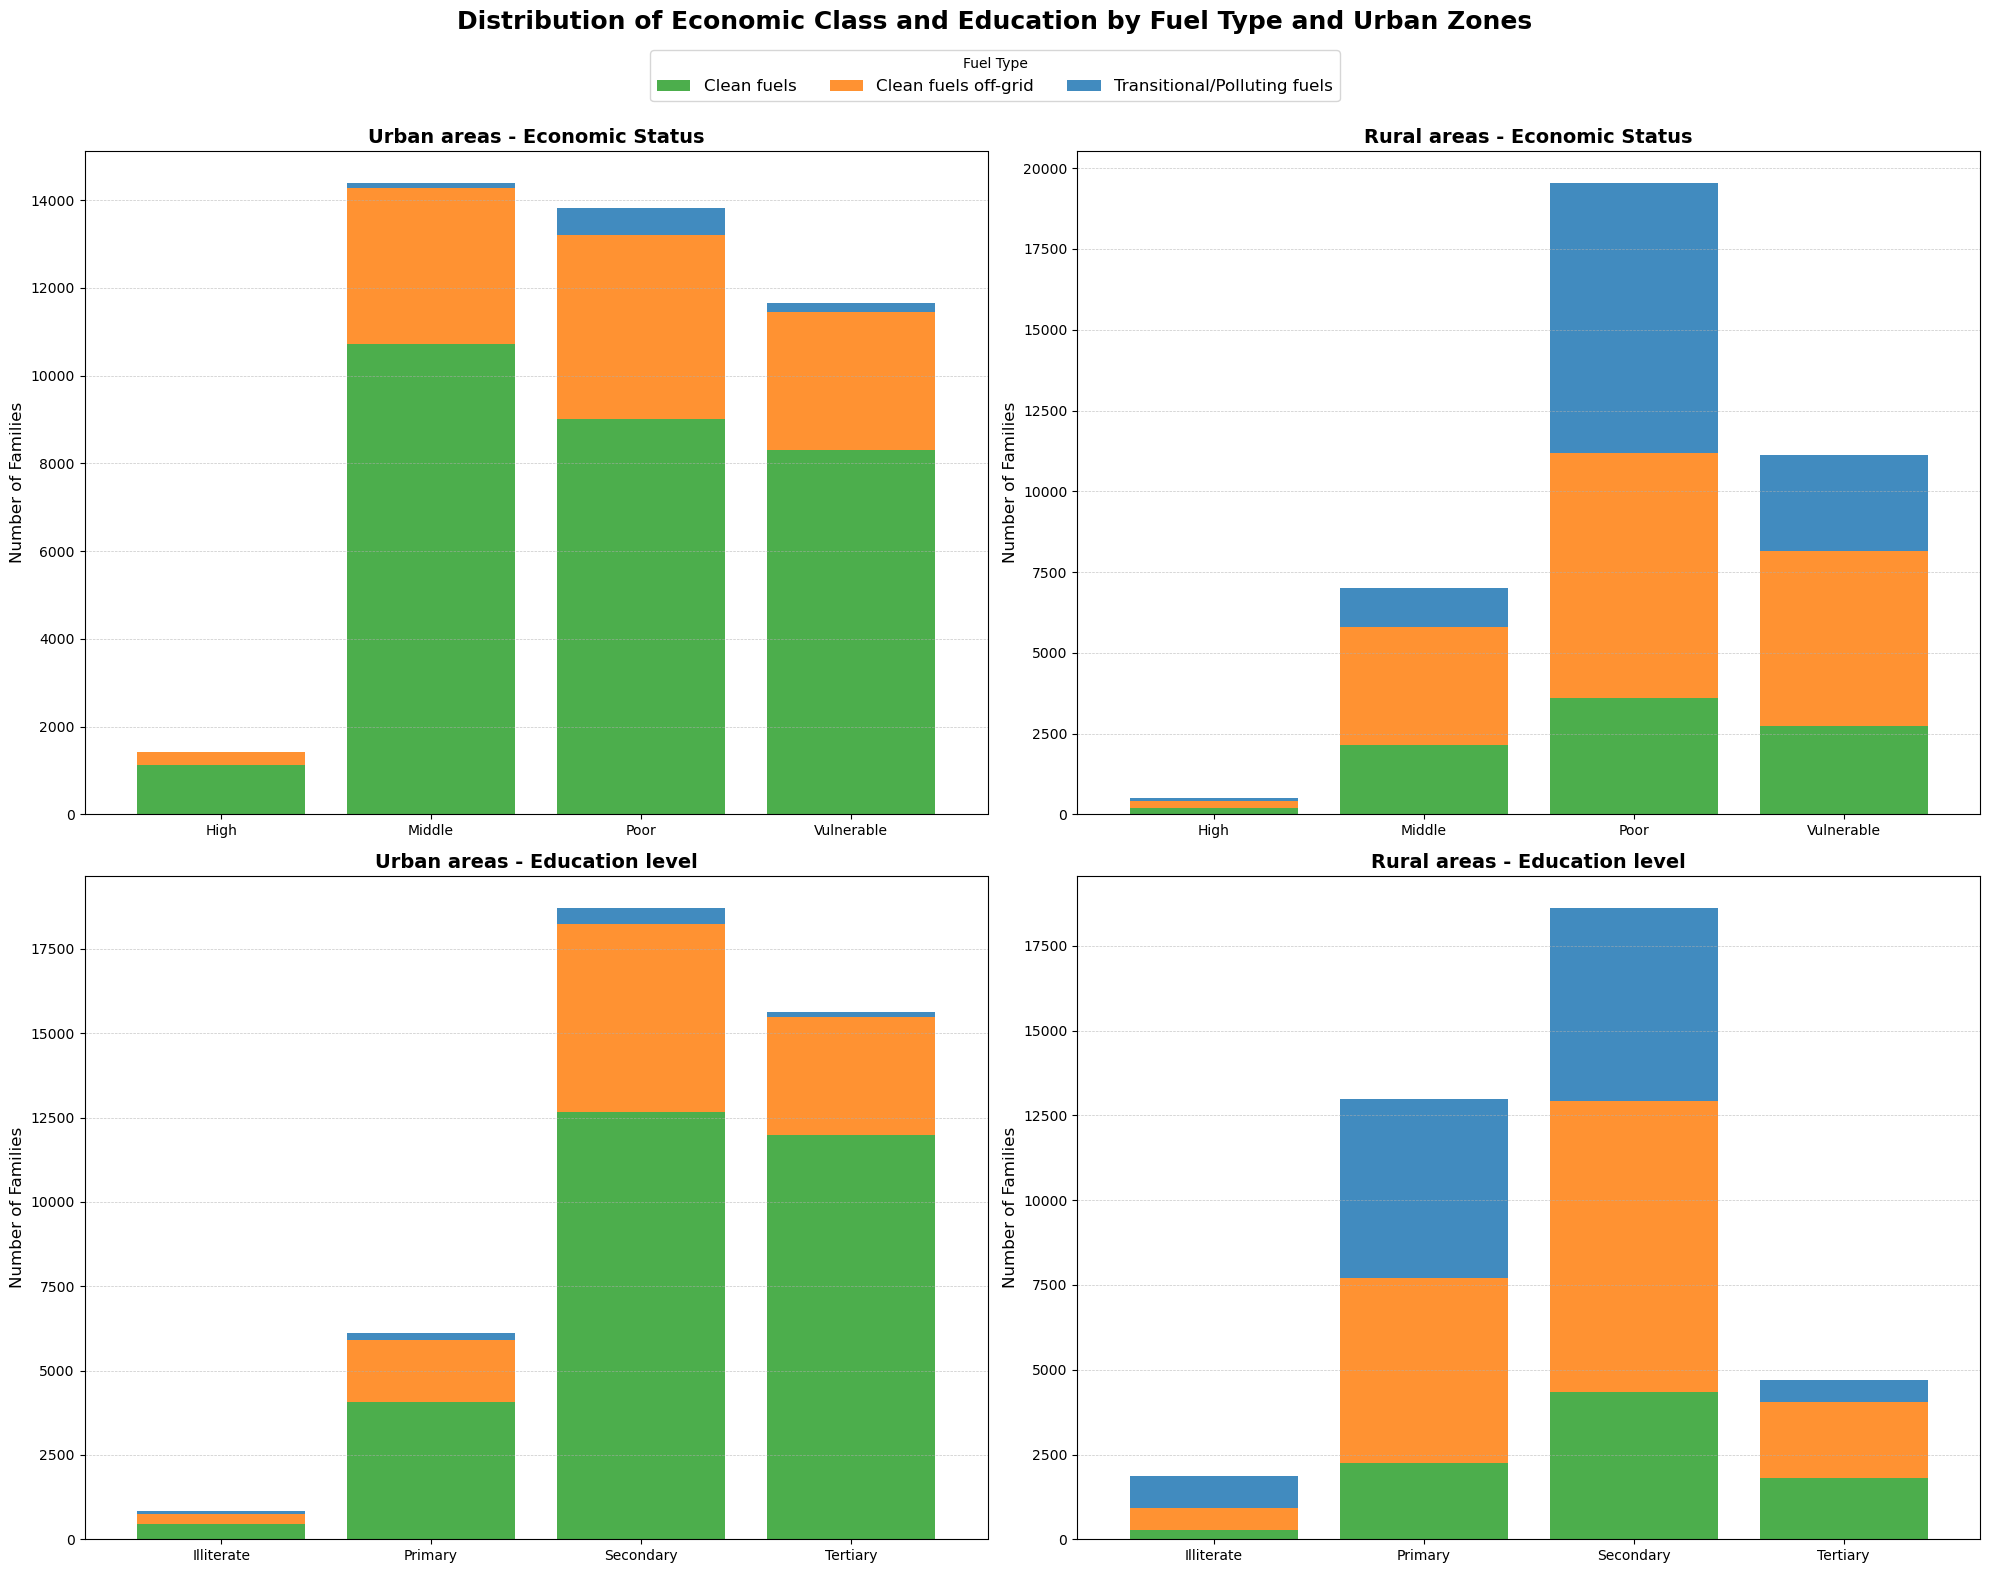

In [36]:
#These lines of code I did based on chat GPT in order to make four subplots, showing urban and rural division in SES and education
variables_to_plot = {"economic_class": "Income Status",
    "max_educ": "Highest Education Level"}
urban_conditions = [True, False]  # Urban and Rural areas
titles = ["Urban areas - Economic Status",
    "Rural areas - Economic Status",
    "Urban areas - Education level",
    "Rural areas - Education level"]

# Layout for the plots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# Loop through each variable and urban condition
for idx, (column, variable_title) in enumerate(variables_to_plot.items()):
    for urban_idx, urban_condition in enumerate(urban_conditions):
        # Filtering the data for urban or rural areas
        filtered_data = db_main[db_main["urban"] == urban_condition]

        # I created a crosstab grouped by the variable and main cooking fuel
        crosstab = pd.crosstab(index=filtered_data[column], columns=filtered_data["who_fuel"])
        crosstab.plot(kind='bar',
                      stacked=True,
                      ax=axes[idx * 2 + urban_idx],
                      color=["#2CA02C", "#FF7F0E", "#1F77B4"],
                      alpha=0.85,
                      width=0.8,
                      legend=False) 
        axes[idx * 2 + urban_idx].set_title(titles[idx * 2 + urban_idx], fontsize=14, weight="bold")
        axes[idx * 2 + urban_idx].set_xlabel("")  # No x-axis label
        axes[idx * 2 + urban_idx].set_ylabel("Number of Families", fontsize=12)  # y-axis label
        axes[idx * 2 + urban_idx].tick_params(axis="x", rotation=0, labelsize=10)  # Adjust rotation for clarity
        axes[idx * 2 + urban_idx].grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

# Add a single legend for all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Fuel Type", loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 0.96), ncol=3)

plt.suptitle("Distribution of Economic Class and Education by Fuel Type and Urban Zones", fontsize=18, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

# Models
In the next lines of code, the models will be trained. Starting from separating the dependent and independent variables, then splitting the data into training and test sets in order to train the multinomial logistic model, random forest, xgboost and svm respectively.

In [177]:
Xcols= ["economic_class","garbage","water","kitchen", 'people_count', 'urban',"road_access", "house_type", 
        "sewage", 'max_educ', 'max_age',"fridge","stove","green_access", "house_tenancy"]
ycols=["who_fuel"]

In [178]:
#define the x-variables (input) and y-variable (outcome of classification)
X = db_main[Xcols]
y = db_main[ycols]

In [179]:
# To standardize the numeric variables by the z-score standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [180]:
# Standardization of the numeric variables
X[numeric_data.columns] = scaler.fit_transform(X[numeric_data.columns])

In [181]:
X[numeric_data.columns].head()

,people_count,max_age,green_access
0,-0.444011,-0.547458,0.406383
1,1.371174,0.096243,0.910346
2,-0.444011,1.442165,1.076799
3,-0.444011,0.739945,0.406383
4,-0.444011,-0.430422,0.249986


## Encoding
The categorical variables were encoded by one hot encoding procedure and one dummy variable was dropped in order to avoid multicolinearity.

In [182]:
# Create dummy variables for all categorical columns that is not boolean
categorical_data = X.select_dtypes(include=[object])
for col in categorical_data.columns:
    X = pd.concat([X, pd.get_dummies(X[col], prefix=col)], axis=1)

# Drop original categorical columns if desired
X.drop(columns=categorical_data.columns, inplace=True)
X

,garbage,water,kitchen,people_count,urban,sewage,max_age,fridge,stove,green_access,...,house_type_apartment,house_type_house,house_type_others,max_educ_Illiterate,max_educ_Primary,max_educ_Secondary,max_educ_Tertiary,house_tenancy_Collective,house_tenancy_Own/No payment,house_tenancy_Rent/Mortgage
0,True,True,True,-0.444011,True,True,-0.547458,True,True,0.406383,...,False,True,False,False,False,True,False,False,False,True
1,True,True,True,1.371174,False,False,0.096243,True,True,0.910346,...,False,True,False,False,False,True,False,True,False,False
2,False,True,True,-0.444011,False,False,1.442165,True,True,1.076799,...,False,True,False,False,False,True,False,False,True,False
3,False,True,True,-0.444011,False,False,0.739945,True,True,0.406383,...,False,True,False,False,True,False,False,False,True,False
4,True,True,True,-0.444011,True,True,-0.430422,True,True,0.249986,...,True,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86400,True,True,True,-0.444011,True,True,-0.488940,True,True,-0.066021,...,False,True,False,False,False,True,False,False,False,True
86401,False,True,False,0.309359,False,False,-1.600788,True,True,-1.462467,...,False,True,False,False,False,True,False,True,False,False
86402,True,True,True,-0.444011,False,True,-0.371903,True,True,0.910346,...,False,True,False,False,False,True,False,False,True,False
86403,True,True,True,-1.505826,False,True,0.622908,True,True,0.910346,...,False,True,False,False,False,True,False,False,True,False


The discarded variables to avoid multicolinearity were:

``economic_class_High``, ``road_access_Sidewalk``, ``house_type_others``, ``max_educ_Illiterate``,``house_tenancy_Collective``

In [184]:
X=X[['garbage', 'water', 'kitchen', 'people_count', 'urban', 'sewage',
        'max_age', 'fridge', 'stove', 'green_access',
       'economic_class_Middle', 'economic_class_Poor',
       'economic_class_Vulnerable', 'road_access_Path_or_river',
       'road_access_Paved','road_access_Unpaved',
       'house_type_apartment', 'house_type_house',
       'max_educ_Tertiary', 'max_educ_Primary', 'max_educ_Secondary',
       'house_tenancy_Own/No payment', 'house_tenancy_Rent/Mortgage']]

In [185]:
from sklearn.preprocessing import LabelEncoder
Label = LabelEncoder() #easy labelling with LabelEncoder
y = y.reset_index(drop=True)
y=pd.concat([y,pd.DataFrame(Label.fit_transform(y),columns=['labels'])],axis=1)
ylabels=y['labels']
y

,who_fuel,labels
0,Clean fuels,0
1,Clean fuels,0
2,Clean fuels off-grid,1
3,Clean fuels off-grid,1
4,Clean fuels off-grid,1
...,...,...
79434,Clean fuels,0
79435,Clean fuels off-grid,1
79436,Clean fuels,0
79437,Clean fuels off-grid,1


In [186]:
#splits the datasets (both x- and y-variables) into the training and test sets
(X_train, X_test, y_train, y_test) = train_test_split(X, ylabels, train_size=0.7, random_state=1)

## Multinomial logistic model
First, a multinomial logistic model will be trained and interpret in order to compare with the literature review.

In [187]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [188]:
#prediction
y_pred_log=log_model.predict(X_test)
#predict probabilities of allocation of each categories
y_pred_log_prob=log_model.predict_proba(X_test)

In [189]:
#reports the prediction accuracy of the testset
print ('the out of sample test accuracy is : '+ str(round(accuracy_score(y_test, y_pred_log),3)))
#reports the prediction accuracy of the trainset
y_pred_train_log=log_model.predict(X_train) 
print ('the in sample test accuracy is : '+ str(round(accuracy_score(y_train, y_pred_train_log),3)))

the out of sample test accuracy is : 0.725
the in sample test accuracy is : 0.727


In [190]:
#the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79     11403
           1       0.63      0.61      0.62      8390
           2       0.88      0.65      0.75      4039

    accuracy                           0.73     23832
   macro avg       0.75      0.70      0.72     23832
weighted avg       0.73      0.73      0.72     23832



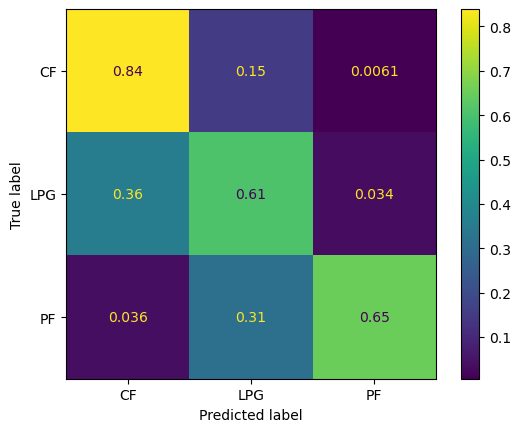

In [192]:
from sklearn.metrics import ConfusionMatrixDisplay
# Define the custom labels
labels_fuels = ['CF', 'LPG', 'PF'] #CF clean fuels PF polluting fuels TF transitional fuels
ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, normalize='true',display_labels=labels_fuels)

## Random Forest
The Gridsearch cross validation was applied to hypertune the model.

In [193]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
rf_model =  RandomForestClassifier() 
param_grid = {'max_depth': [5, 10, 20, 40],
    'n_estimators': [100, 200, 300]} # restricted the grid search to reduce compute time
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2) # what to display
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 40],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [194]:
rf_gcv_model = grid_search.best_estimator_
y_pred_rf=rf_gcv_model.predict(X_test)

In [195]:
#reports the prediction accuracy of the testset
print ('the out of sample test accuracy is : '+ str(round(accuracy_score(y_test, y_pred_rf),3)))
#reports the prediction accuracy of the trainset
y_pred_train_rf=rf_gcv_model.predict(X_train) 
print ('the in sample test accuracy is : '+ str(round(accuracy_score(y_train, y_pred_train_rf),3)))
#the classification report
print(classification_report(y_test, y_pred_rf))

the out of sample test accuracy is : 0.735
the in sample test accuracy is : 0.75
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     11403
           1       0.63      0.65      0.64      8390
           2       0.90      0.64      0.75      4039

    accuracy                           0.73     23832
   macro avg       0.77      0.71      0.73     23832
weighted avg       0.74      0.73      0.73     23832



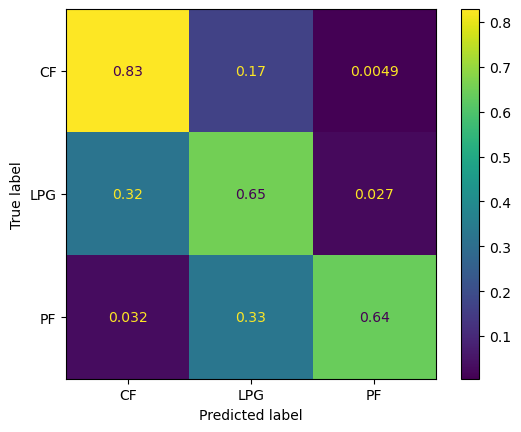

In [196]:
ConfusionMatrixDisplay.from_estimator(rf_gcv_model, X_test, y_test, normalize='true',display_labels=labels_fuels)

## XGBoost
Similar to random forest, a gridsearch cross validation was used to train the model.

In [197]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
n_estimators= [100, 200, 300]
max_depth = [5, 10, 20]
eta= [0.1, 0.01, 0.05]
objective= ['multi:softmax']
num_boost_round = [20]
num_class= [4]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, eta= eta, objective=objective, num_boost_round=num_boost_round, num_class=num_class)
grid_search_xgb = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 3 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2) # what to display
grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.1, 0.01, 0.05], 'max_depth': [5, 10, 20, 40],
                         'n_estimators': [100, 200, 300],
                         'num_boost_round': [20], 'num_class': [4],
                         'objective': ['multi:softmax']},
             verbose=2)

In [198]:
xgb_gcv_model = grid_search_xgb.best_estimator_
y_pred_xgb=xgb_gcv_model.predict(X_test)

In [199]:
#reports the prediction accuracy of the testset
print ('the out of sample test accuracy is : '+ str(round(accuracy_score(y_test, y_pred_xgb),3)))
#reports the prediction accuracy of the trainset
y_pred_train_xgb=xgb_gcv_model.predict(X_train) 
print ('the in sample test accuracy is : '+ str(round(accuracy_score(y_train, y_pred_train_xgb),3)))
#the classification report
print(classification_report(y_test, y_pred_xgb))

the out of sample test accuracy is : 0.737
the in sample test accuracy is : 0.749
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     11403
           1       0.64      0.64      0.64      8390
           2       0.88      0.66      0.76      4039

    accuracy                           0.74     23832
   macro avg       0.76      0.71      0.73     23832
weighted avg       0.74      0.74      0.74     23832



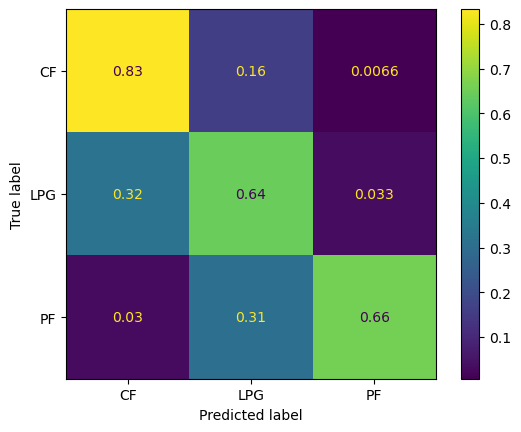

In [200]:
ConfusionMatrixDisplay.from_estimator(xgb_gcv_model, X_test, y_test, normalize='true',display_labels=labels_fuels)

## SVM
Same as the previous models, a gridsearch cross validations was applied.

In [202]:
from sklearn import svm
# Initialize and configure the SVM classifier

param_grid = {'C': [1, 10, 100],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf']}  # Kernel type

svm_model = svm.SVC()

grid_search_svm = GridSearchCV(svm_model, param_grid, refit = True, verbose = 2, n_jobs = -1)

# Train the model on the training data
grid_search_svm.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=2)

In [203]:
svm_gcv_model = grid_search_svm.best_estimator_
y_pred_svm=svm_gcv_model.predict(X_test)

In [204]:
#reports the prediction accuracy of the testset
print ('the out of sample test accuracy is : '+ str(round(accuracy_score(y_test, y_pred_svm),3)))
#reports the prediction accuracy of the trainset
y_pred_train_svm=svm_gcv_model.predict(X_train) 
print ('the in sample test accuracy is : '+ str(round(accuracy_score(y_train, y_pred_train_svm),3)))
#the classification report
print(classification_report(y_test, y_pred_svm))

the out of sample test accuracy is : 0.74
the in sample test accuracy is : 0.754
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     11403
           1       0.64      0.65      0.65      8390
           2       0.89      0.66      0.76      4039

    accuracy                           0.74     23832
   macro avg       0.77      0.71      0.73     23832
weighted avg       0.75      0.74      0.74     23832



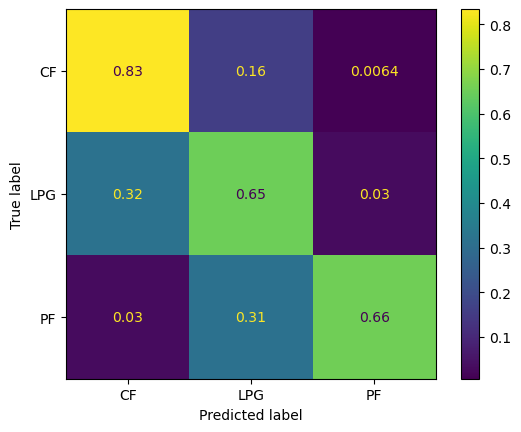

In [205]:
ConfusionMatrixDisplay.from_estimator(svm_gcv_model, X_test, y_test, normalize='true', display_labels=labels_fuels)

## Feature importance
Based on the model with the highest accuracy a feature importance plot was made. Based on the results of each, the best model on the test set according to accuracy score was SVM. Therefore, the feature permutation wll be on the SVM.


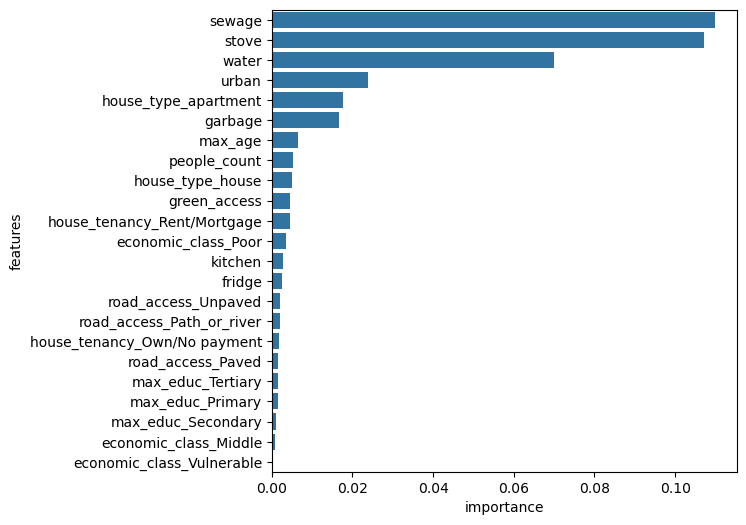

In [206]:
from sklearn.inspection import permutation_importance
# if it doesn't work,you meight need to change n_jobs
result = permutation_importance(
    svm_gcv_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
coef = pd.DataFrame(result.importances_mean,index=X.columns,columns=['importance'])
coef = coef.reset_index()
coef.columns=['features','importance']
coef['importance']=np.abs(coef['importance'])
coef=coef.sort_values(by='importance',ascending=False)
plt.figure(figsize=(6,6))

sns.barplot(x='importance',y='features',data=coef,)
plt.show()